In [1]:
# Импорт библиотек
import numpy as np
import json
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Простяков Н.А. Номер по списку - 14
rand_seed = 14
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

# Использование CPU

device = torch.device('cpu')

In [3]:
# Загрузка датасета MNIST
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

In [4]:
# Загрузка датасета CIFAR-10
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Настройка и загрузка DataLoader
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

In [6]:
# Загрузка и оценка стойкости модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10
fgsm_eps = 0.2

model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=device))

evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')

deep_args = [64, 10, 0.02, 100]
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


In [7]:
# Загрузка и оценка стойкости модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10
fgsm_eps = 0.1

model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=device))

evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')

deep_args = [64, 10, 0.02, 100]
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


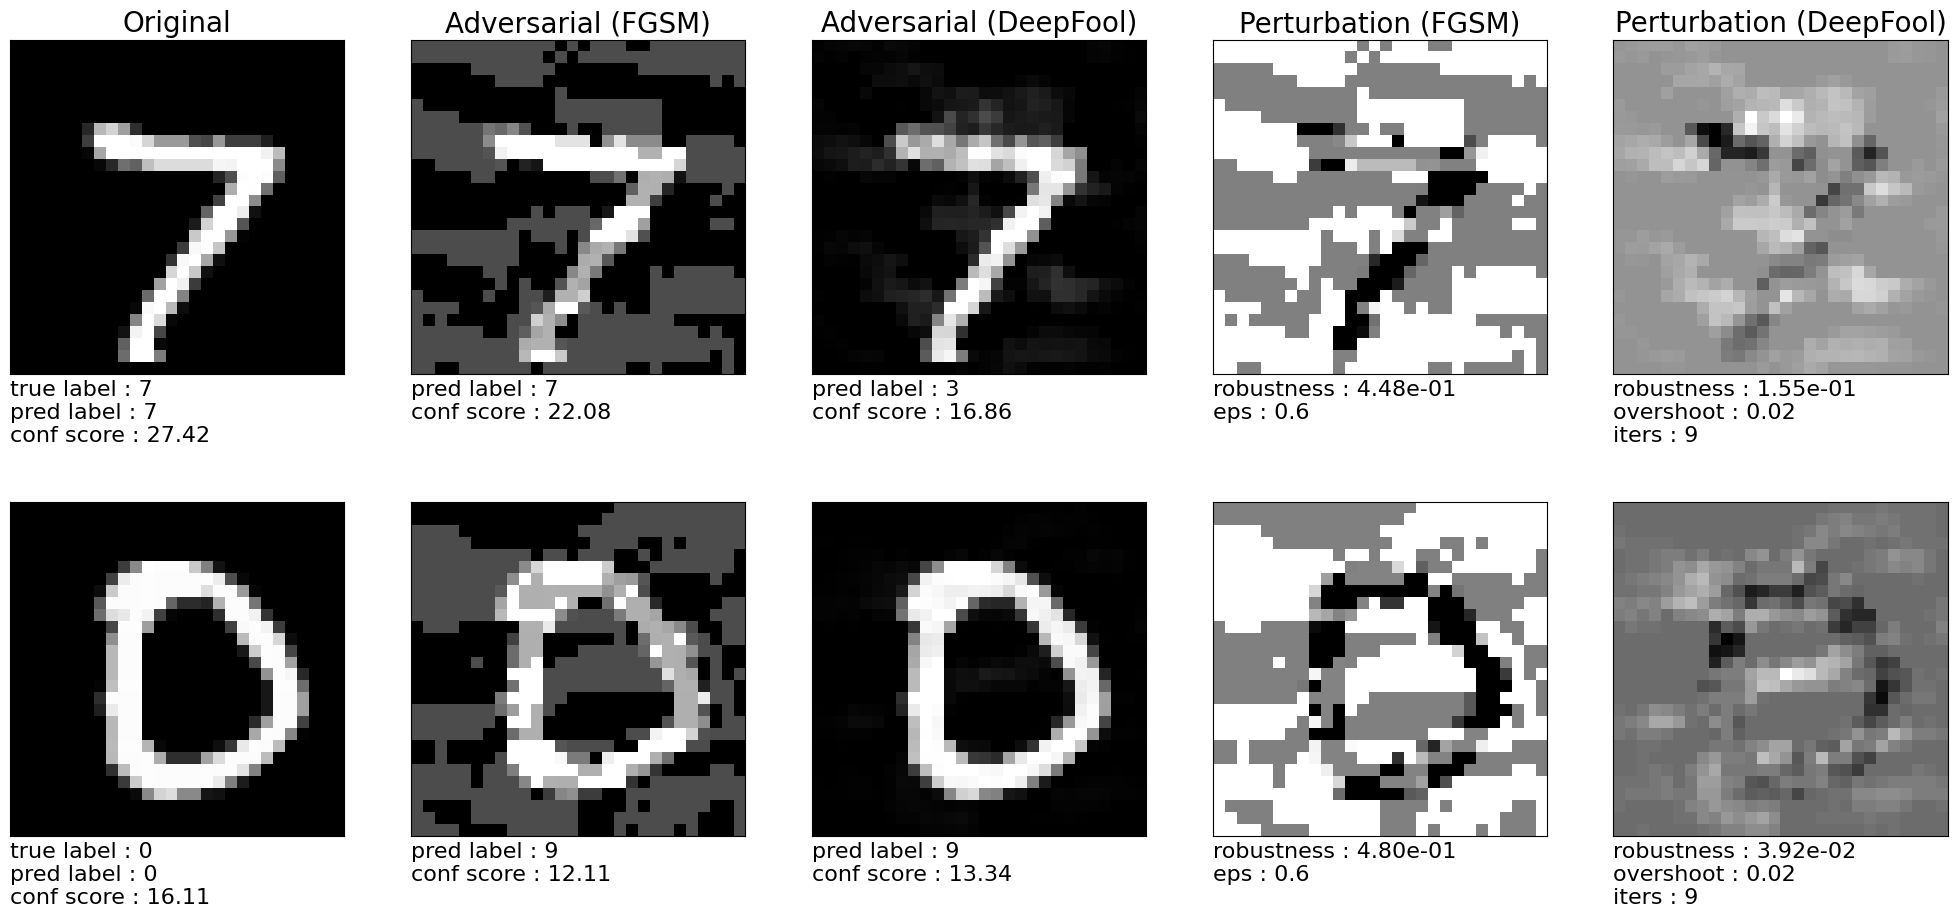

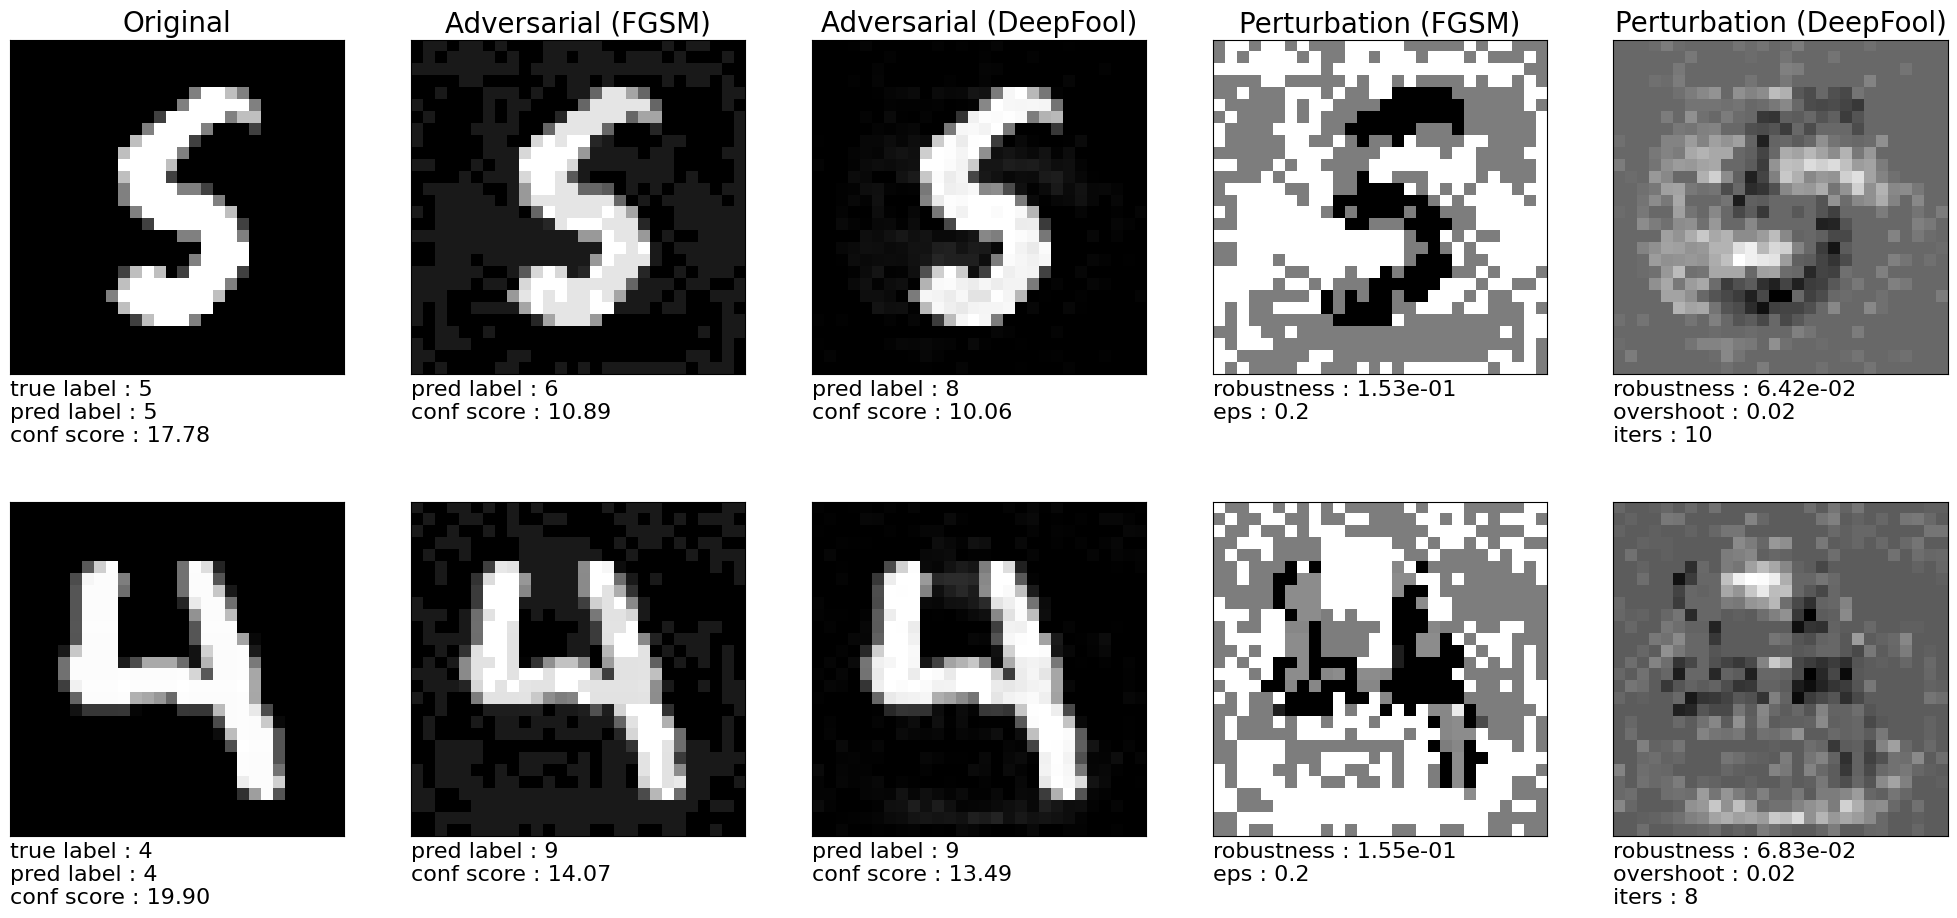

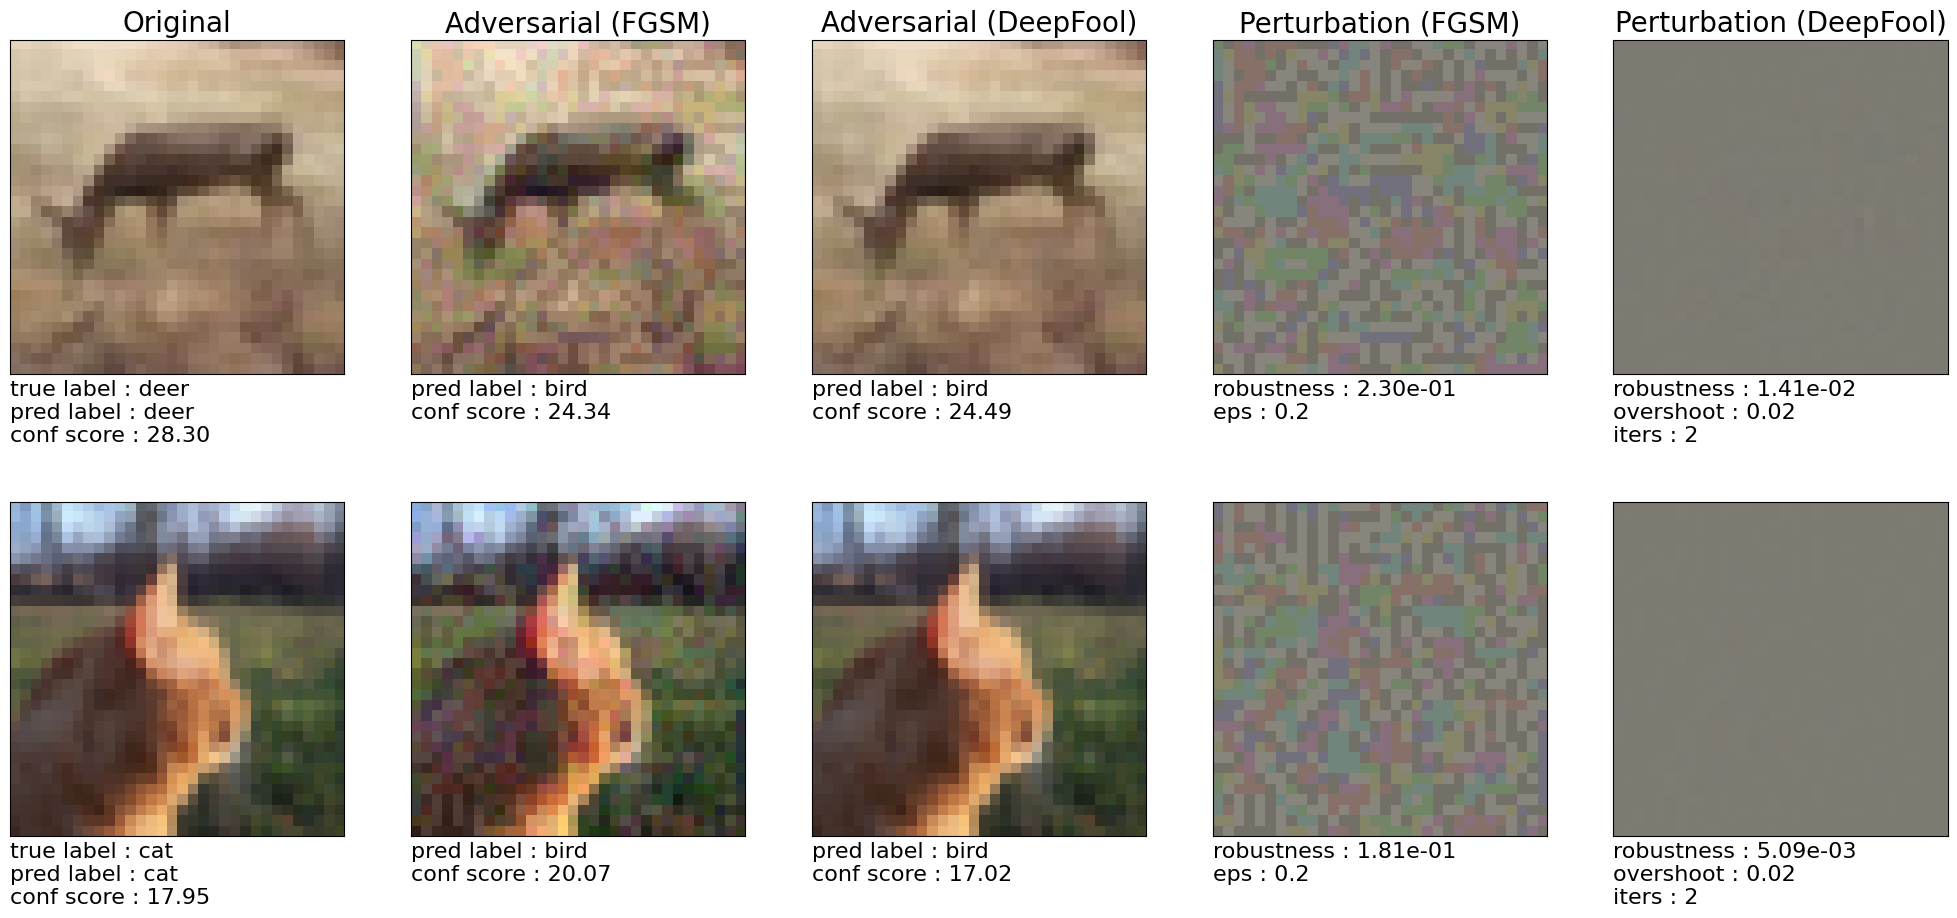

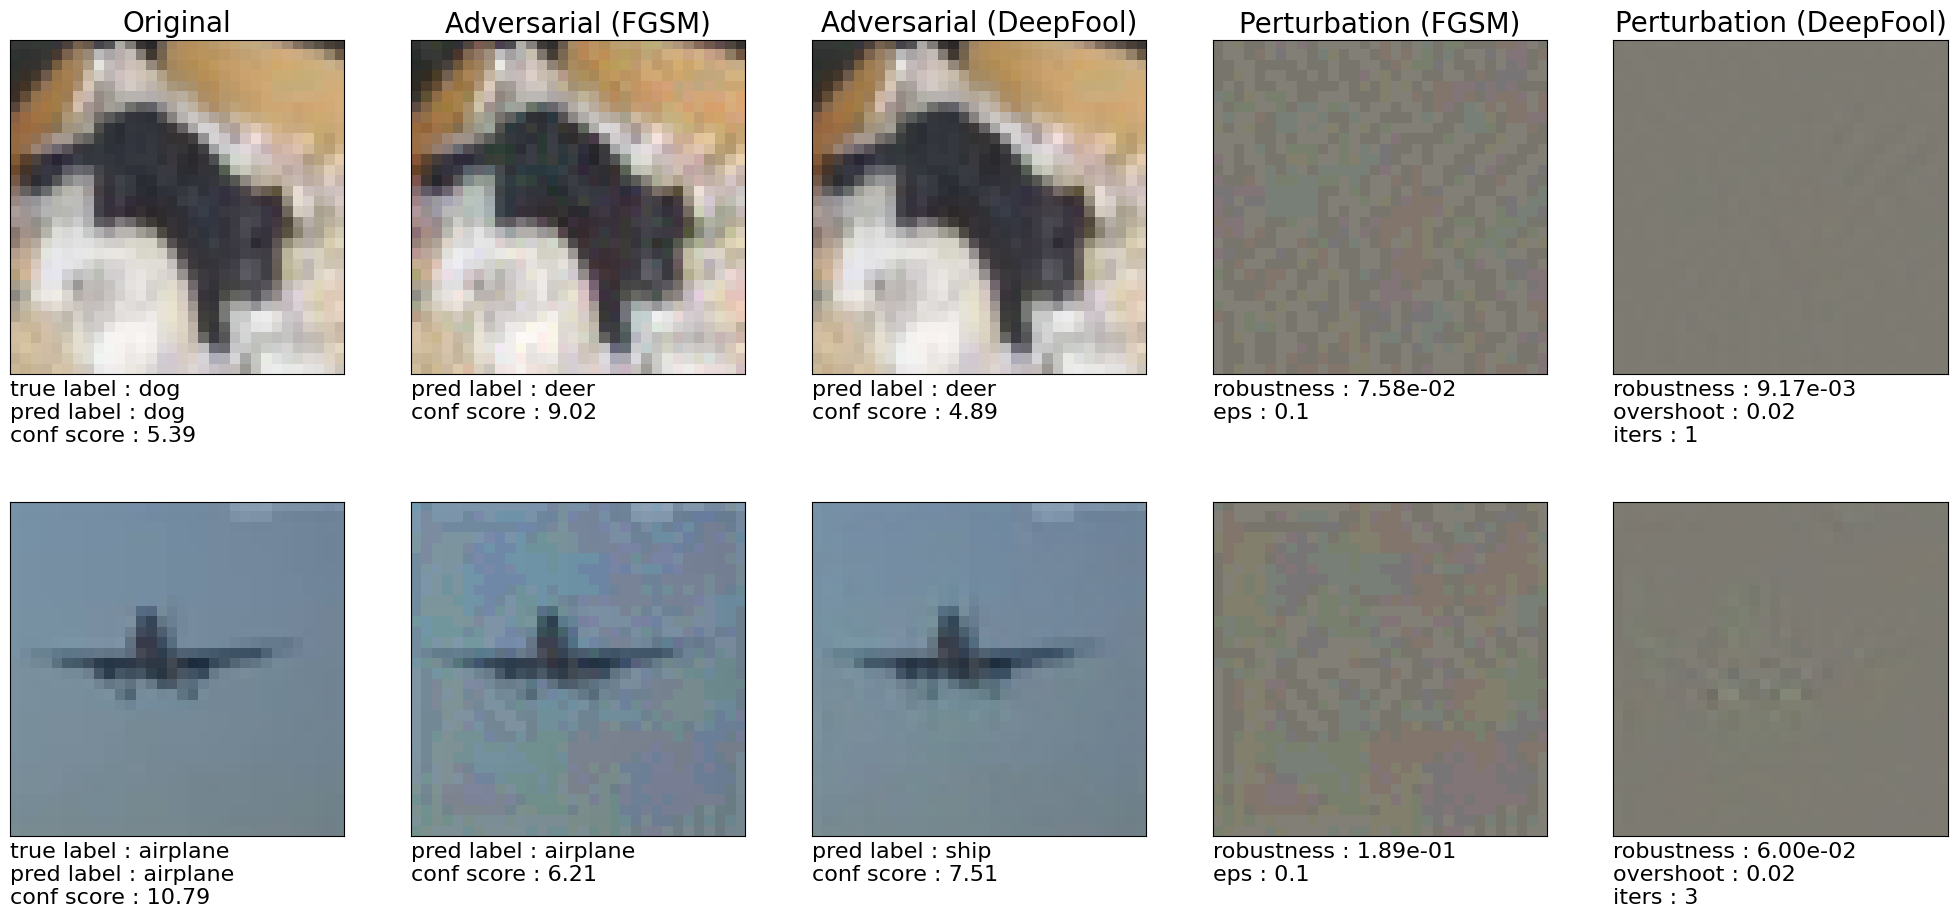

In [8]:
# LeNet MNIST
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

# FCNet MNIST
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=torch.device('cpu')))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

# Network-in-Network CIFAR-10
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

# LeNet CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)


if device.type == 'cuda': torch.cuda.empty_cache()

fgsm_eps =  0.001
LeNet MNIST


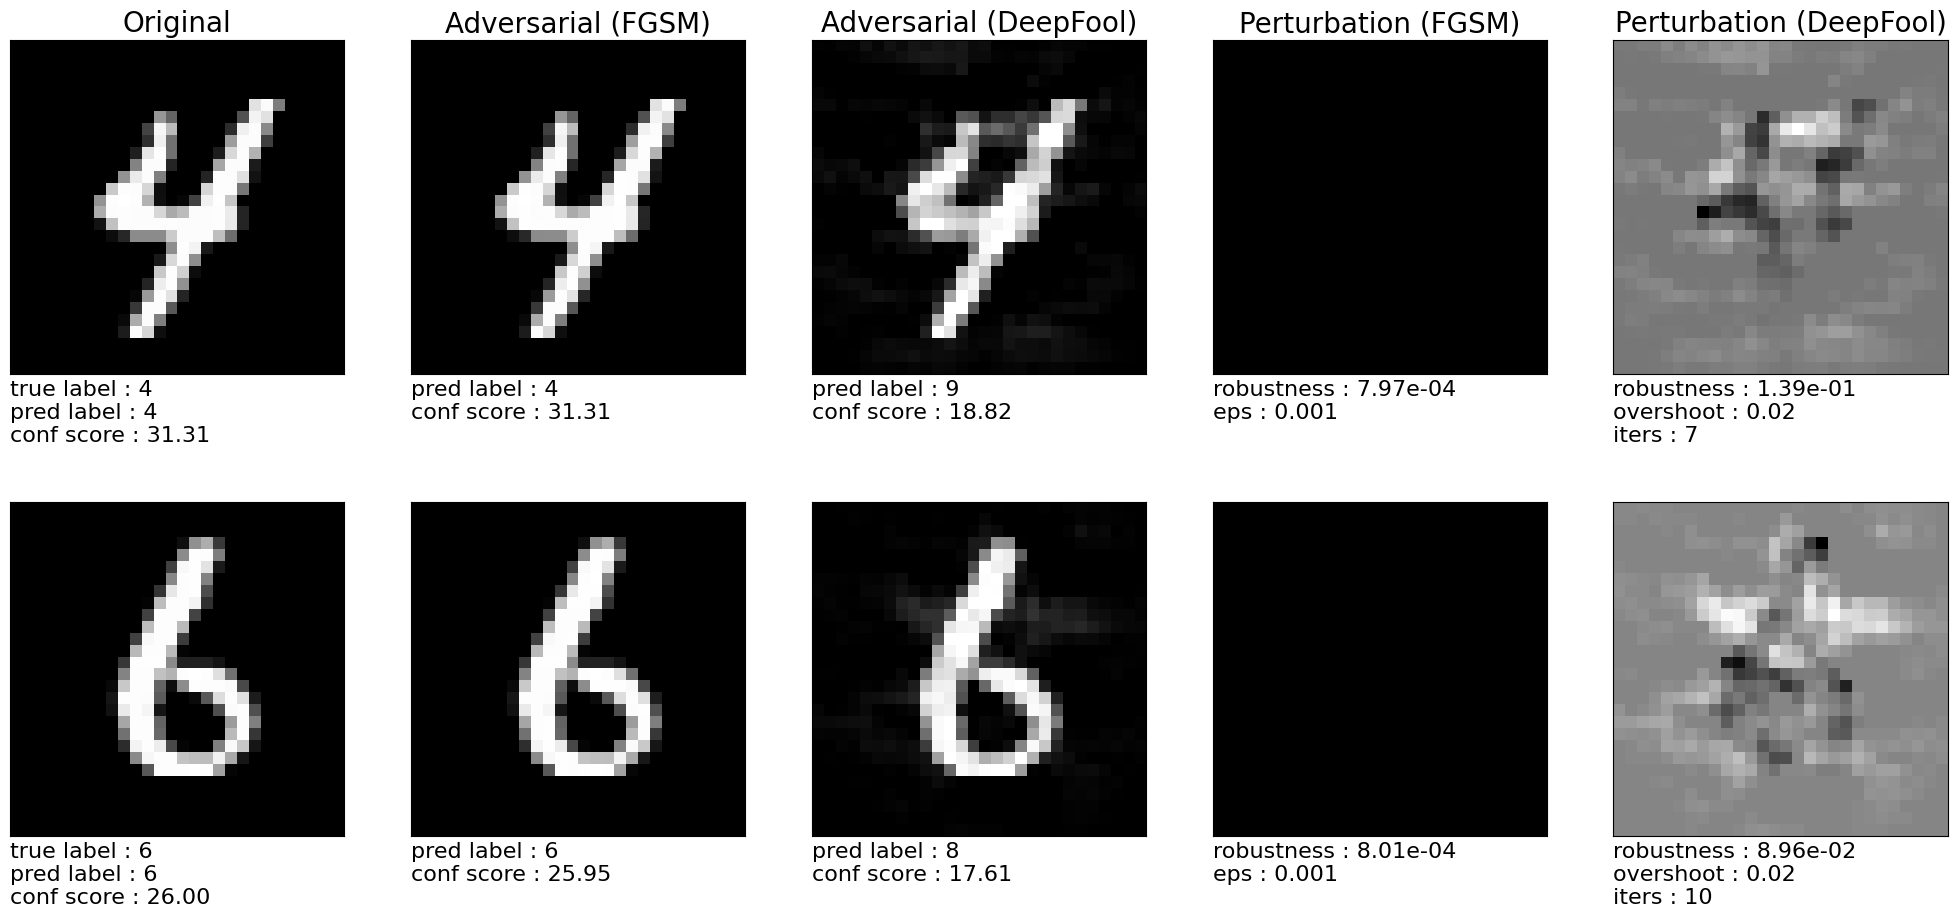

FCNet


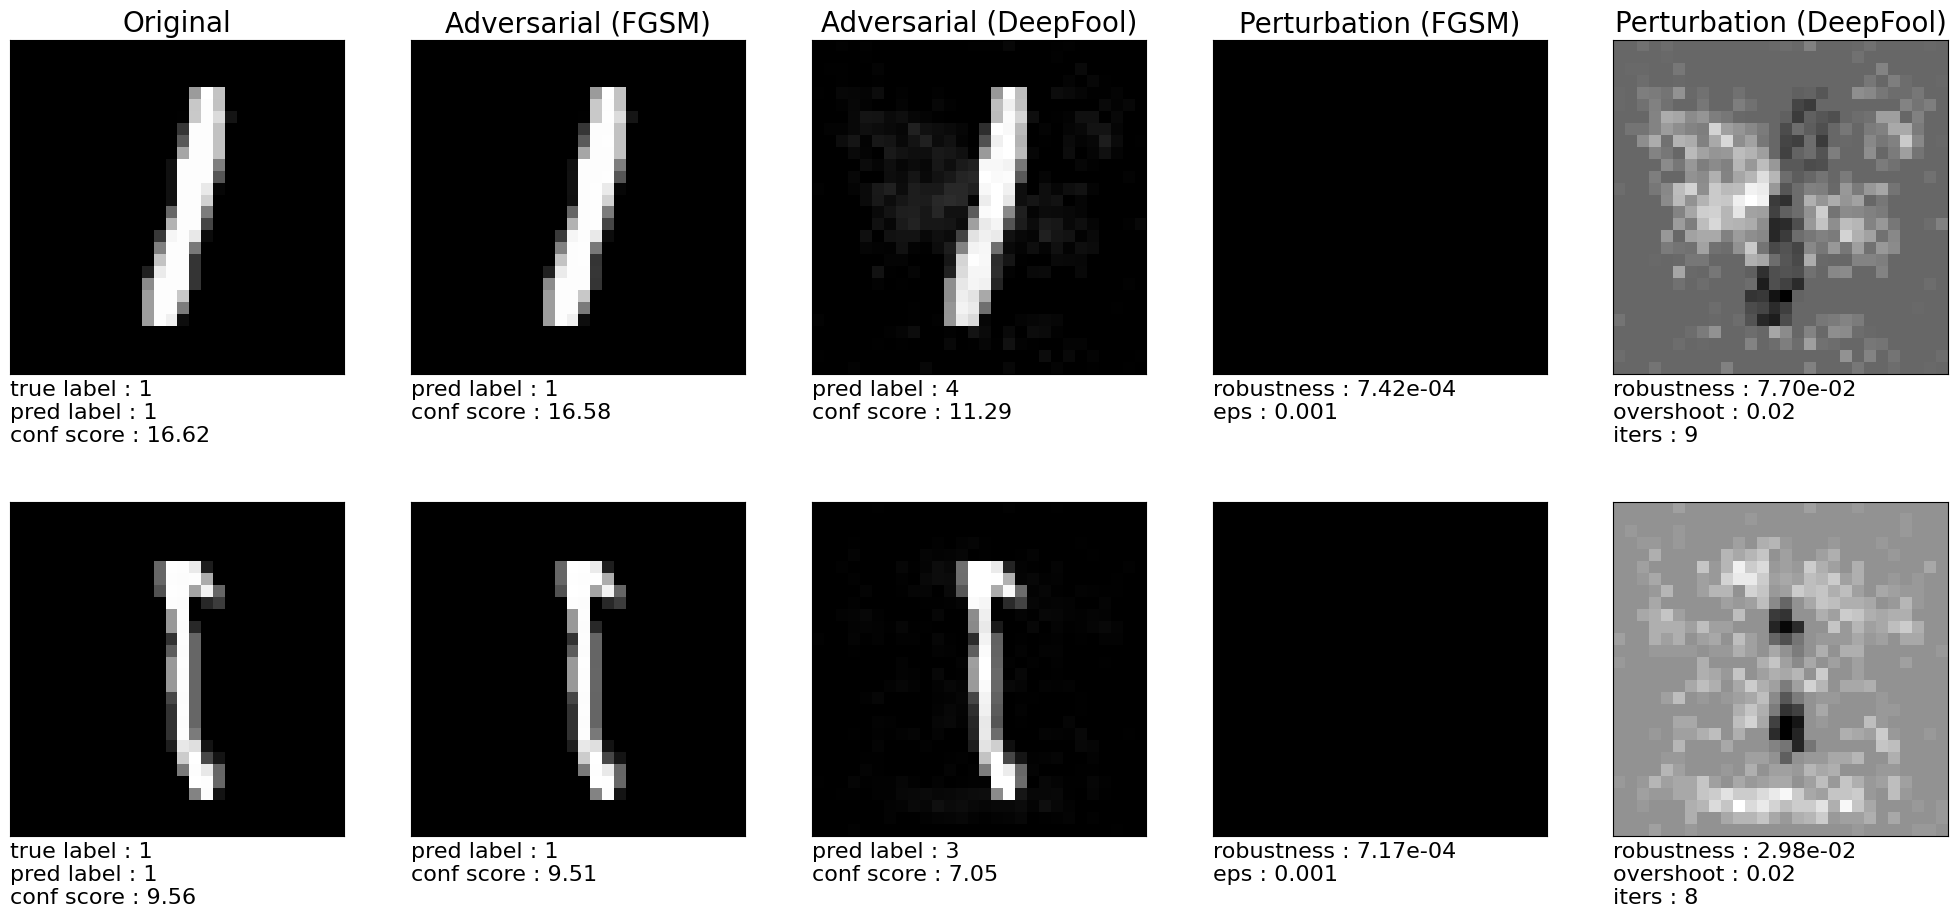

NiN


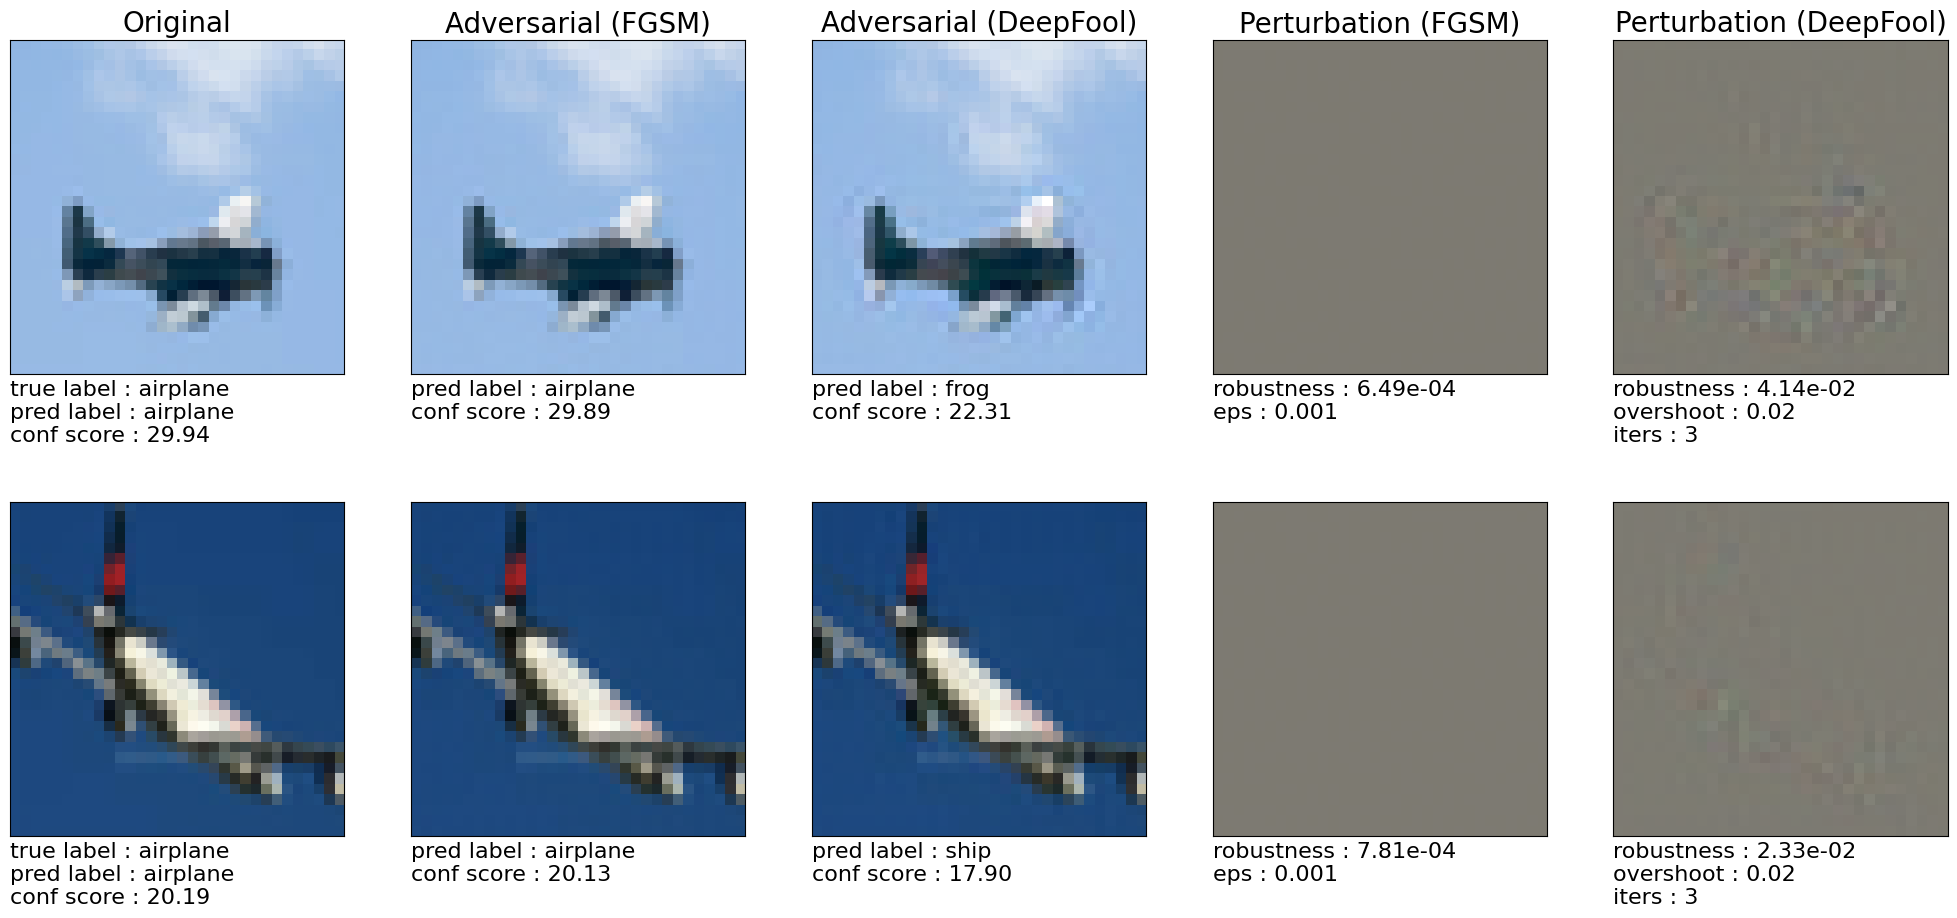

LeNet CIFAR


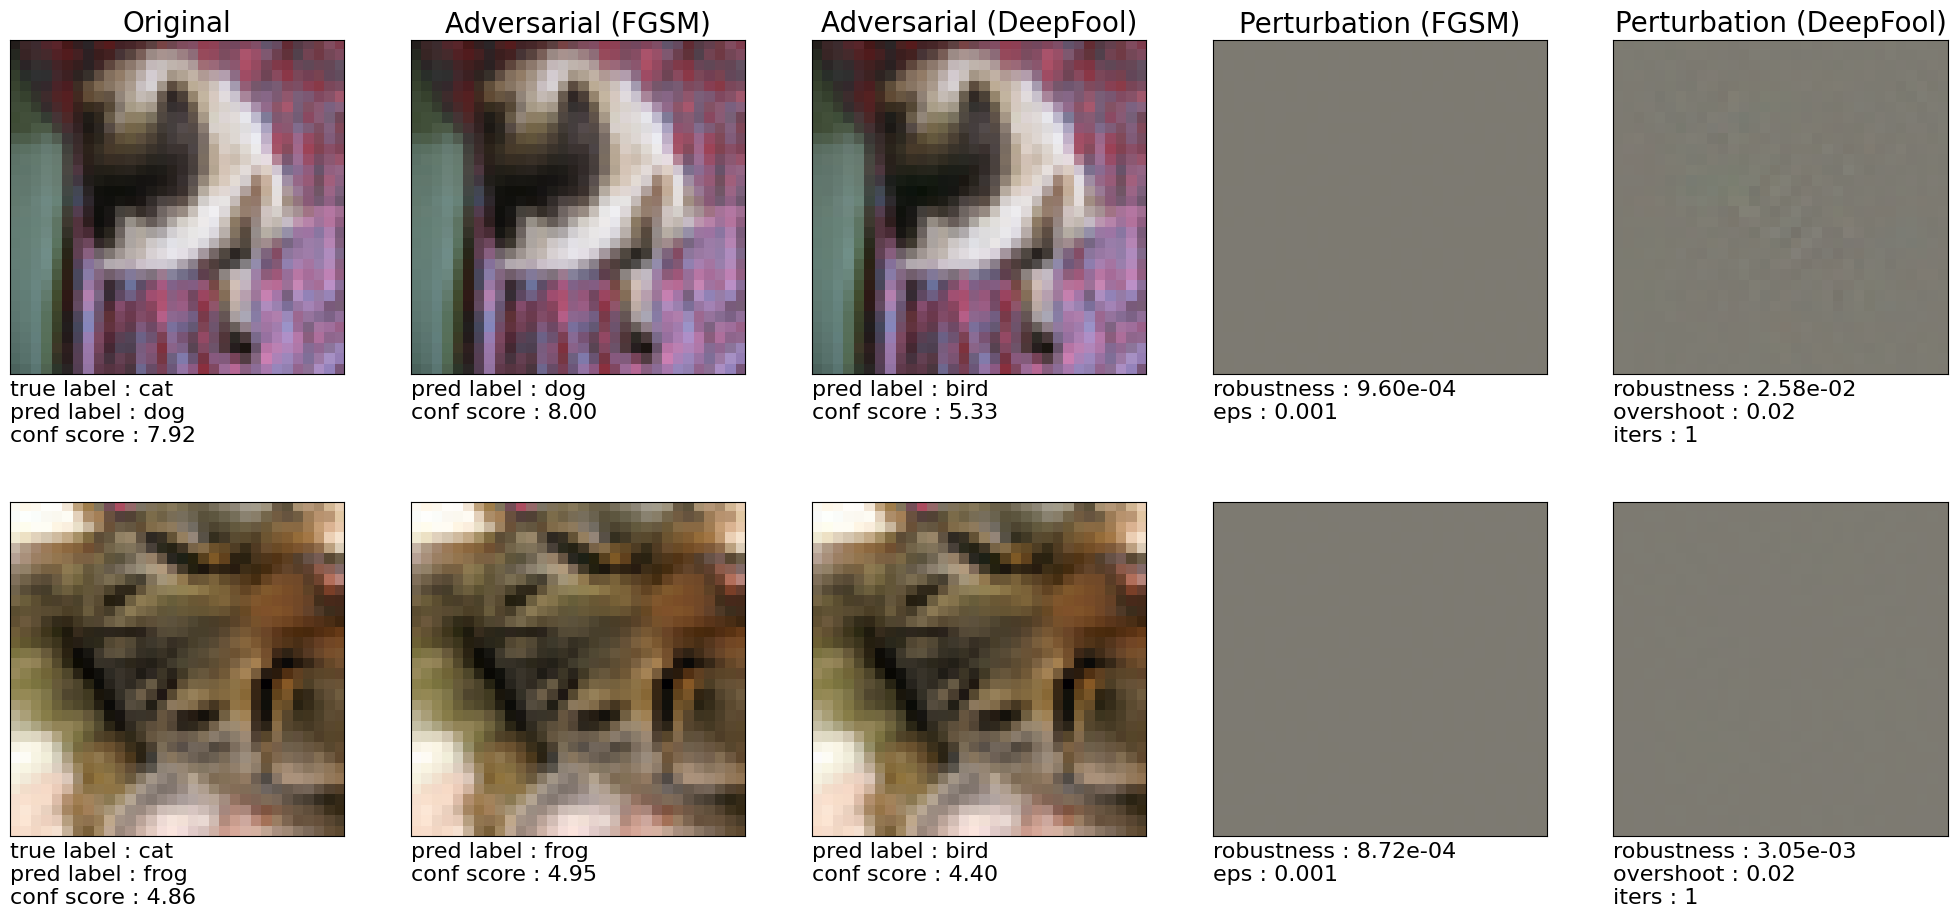

fgsm_eps =  0.02
LeNet MNIST


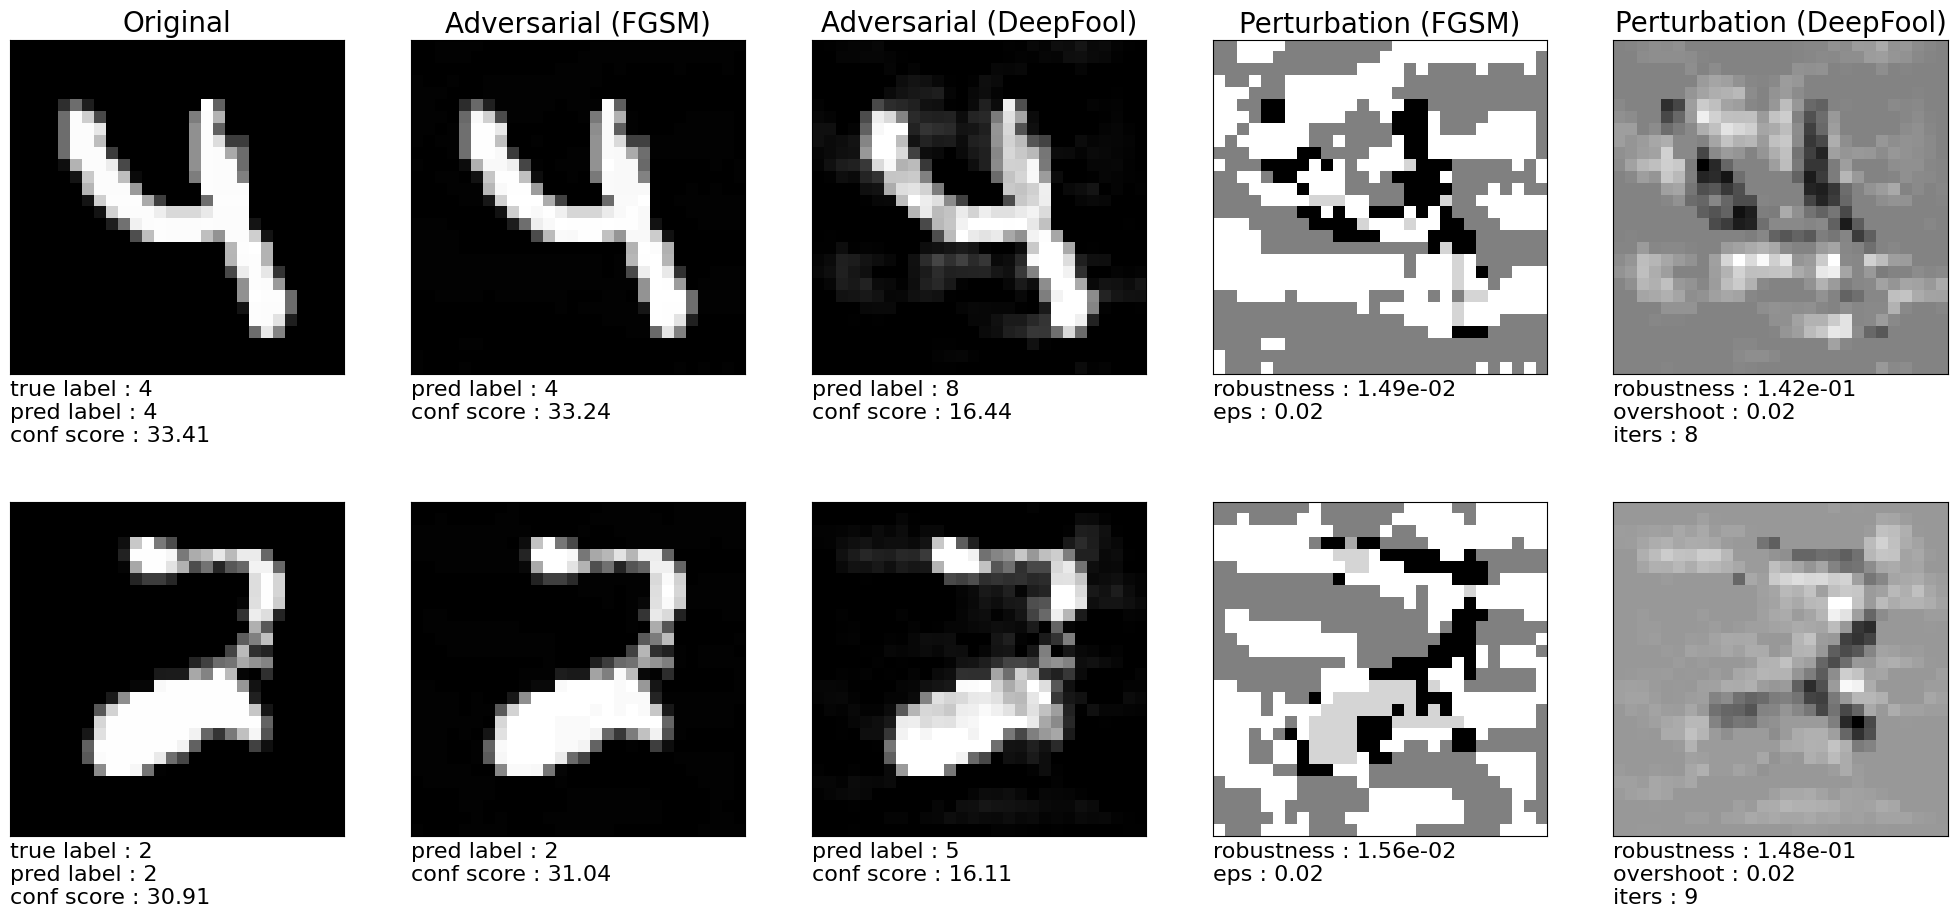

FCNet


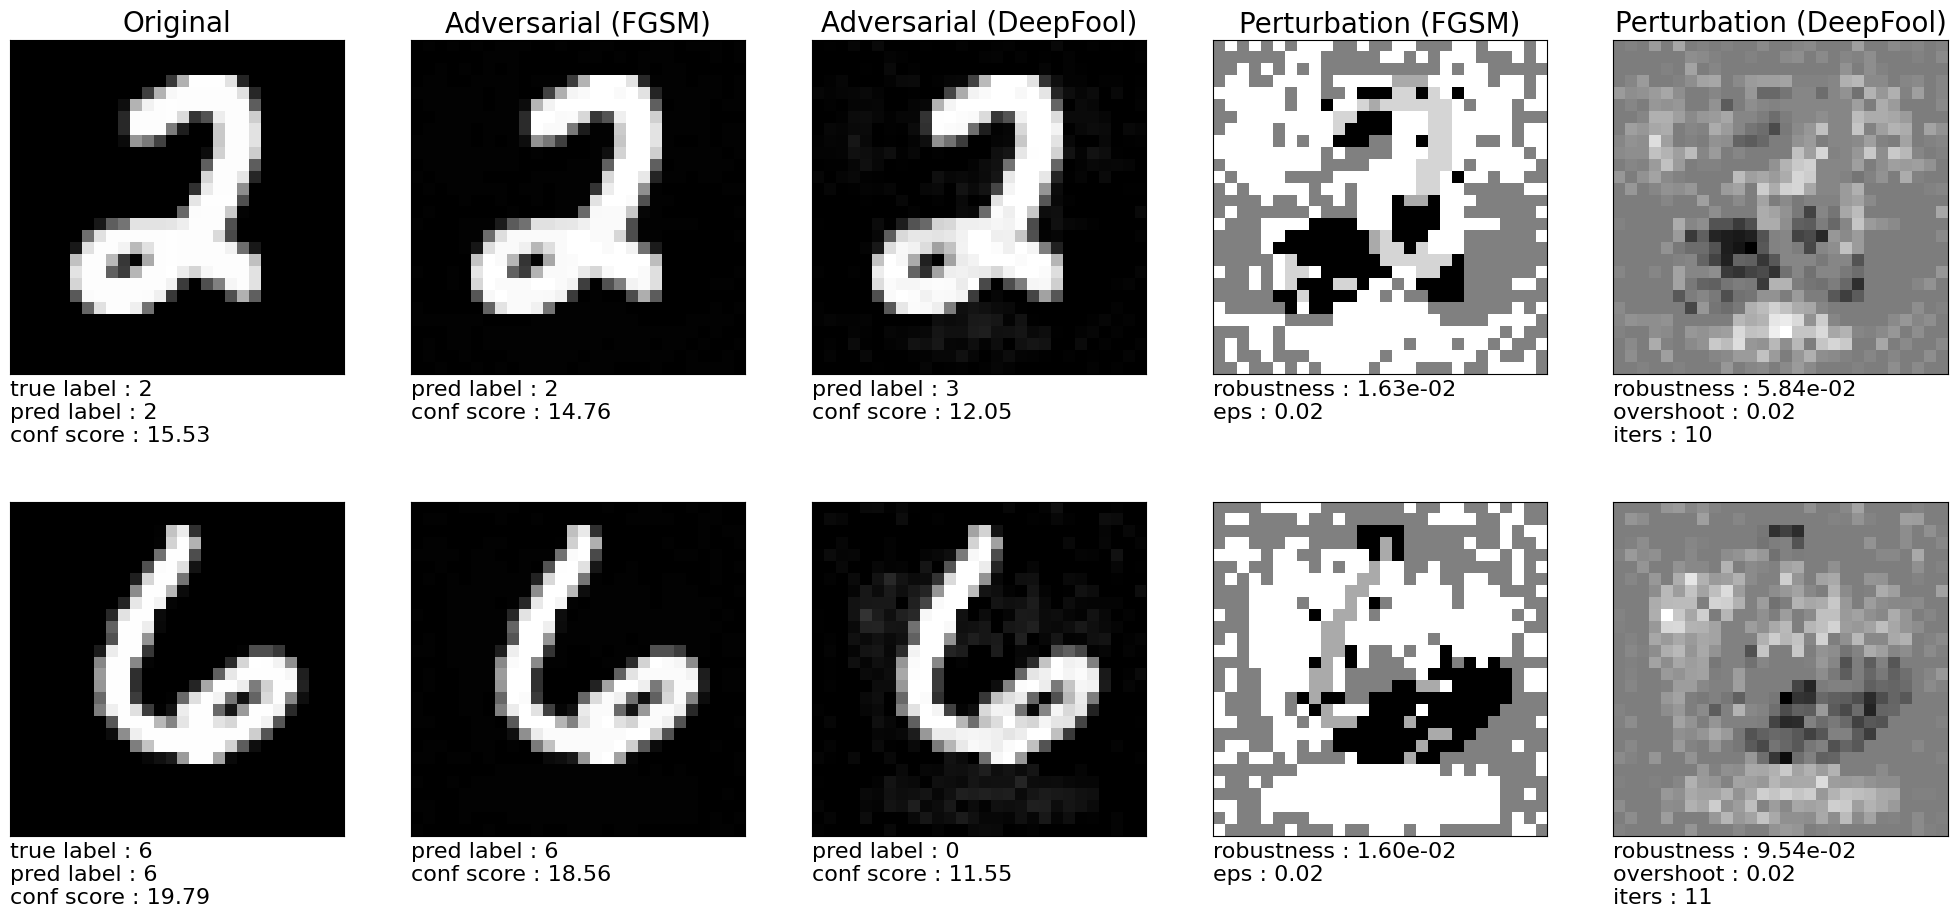

NiN


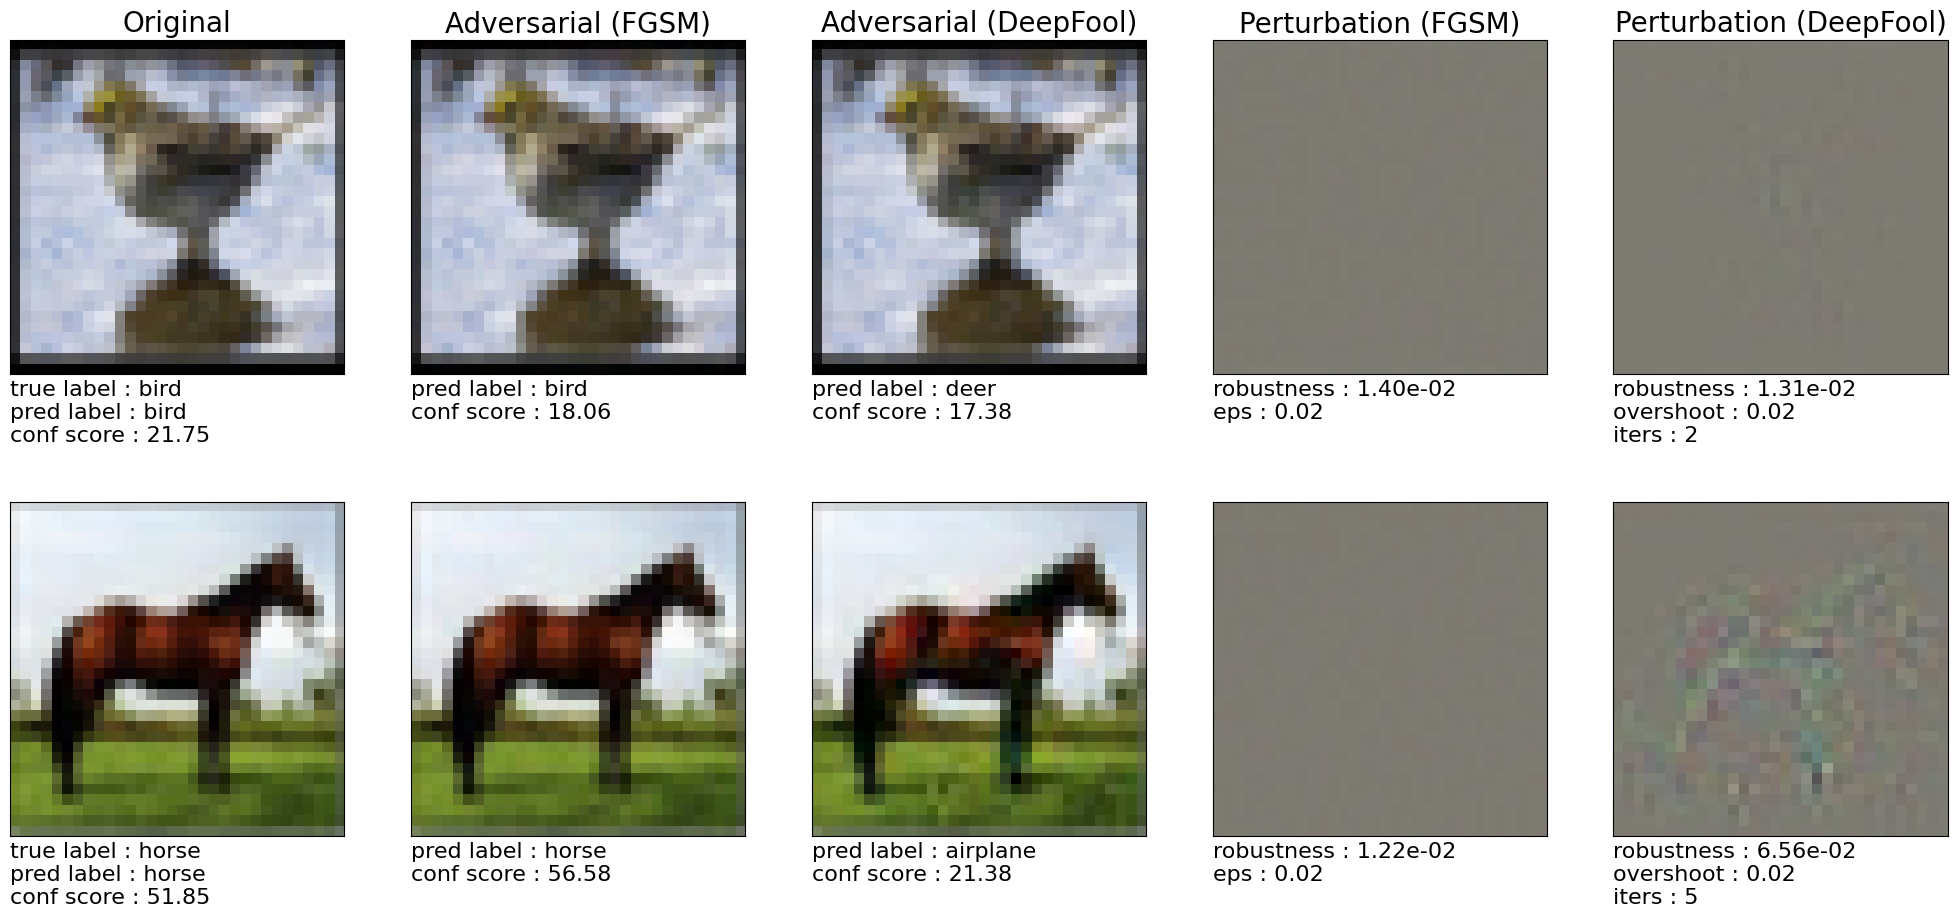

LeNet CIFAR


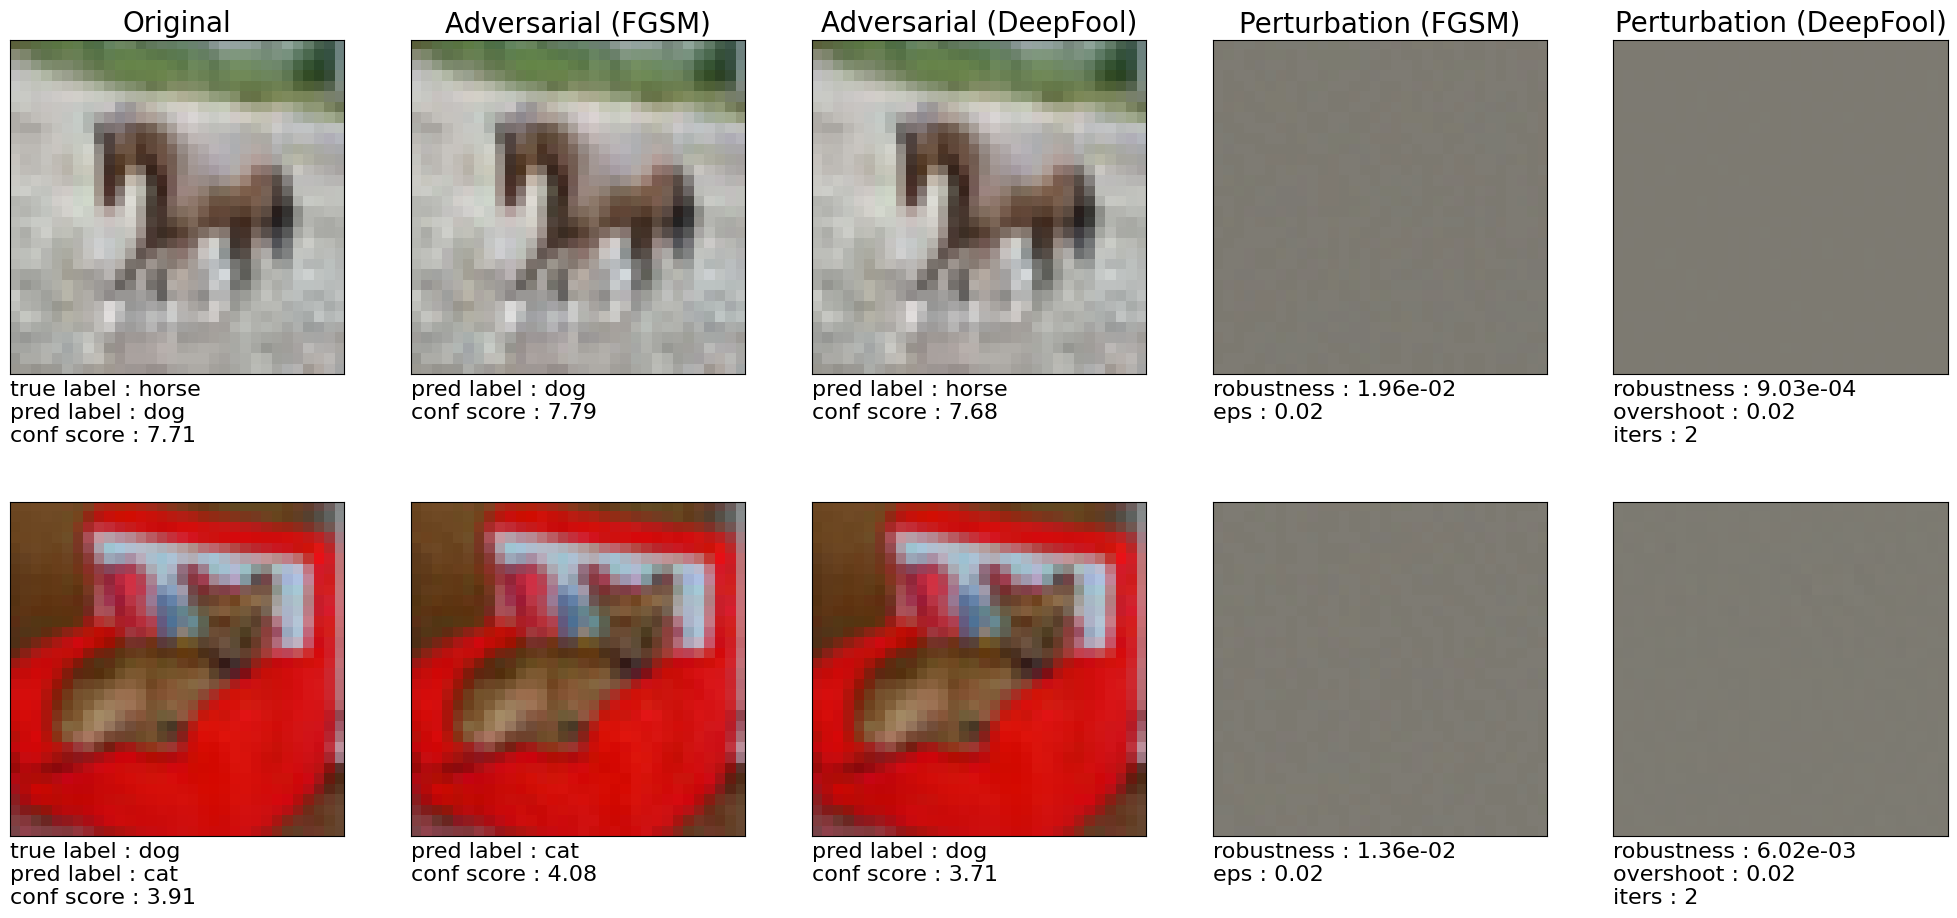

fgsm_eps =  0.5
LeNet MNIST


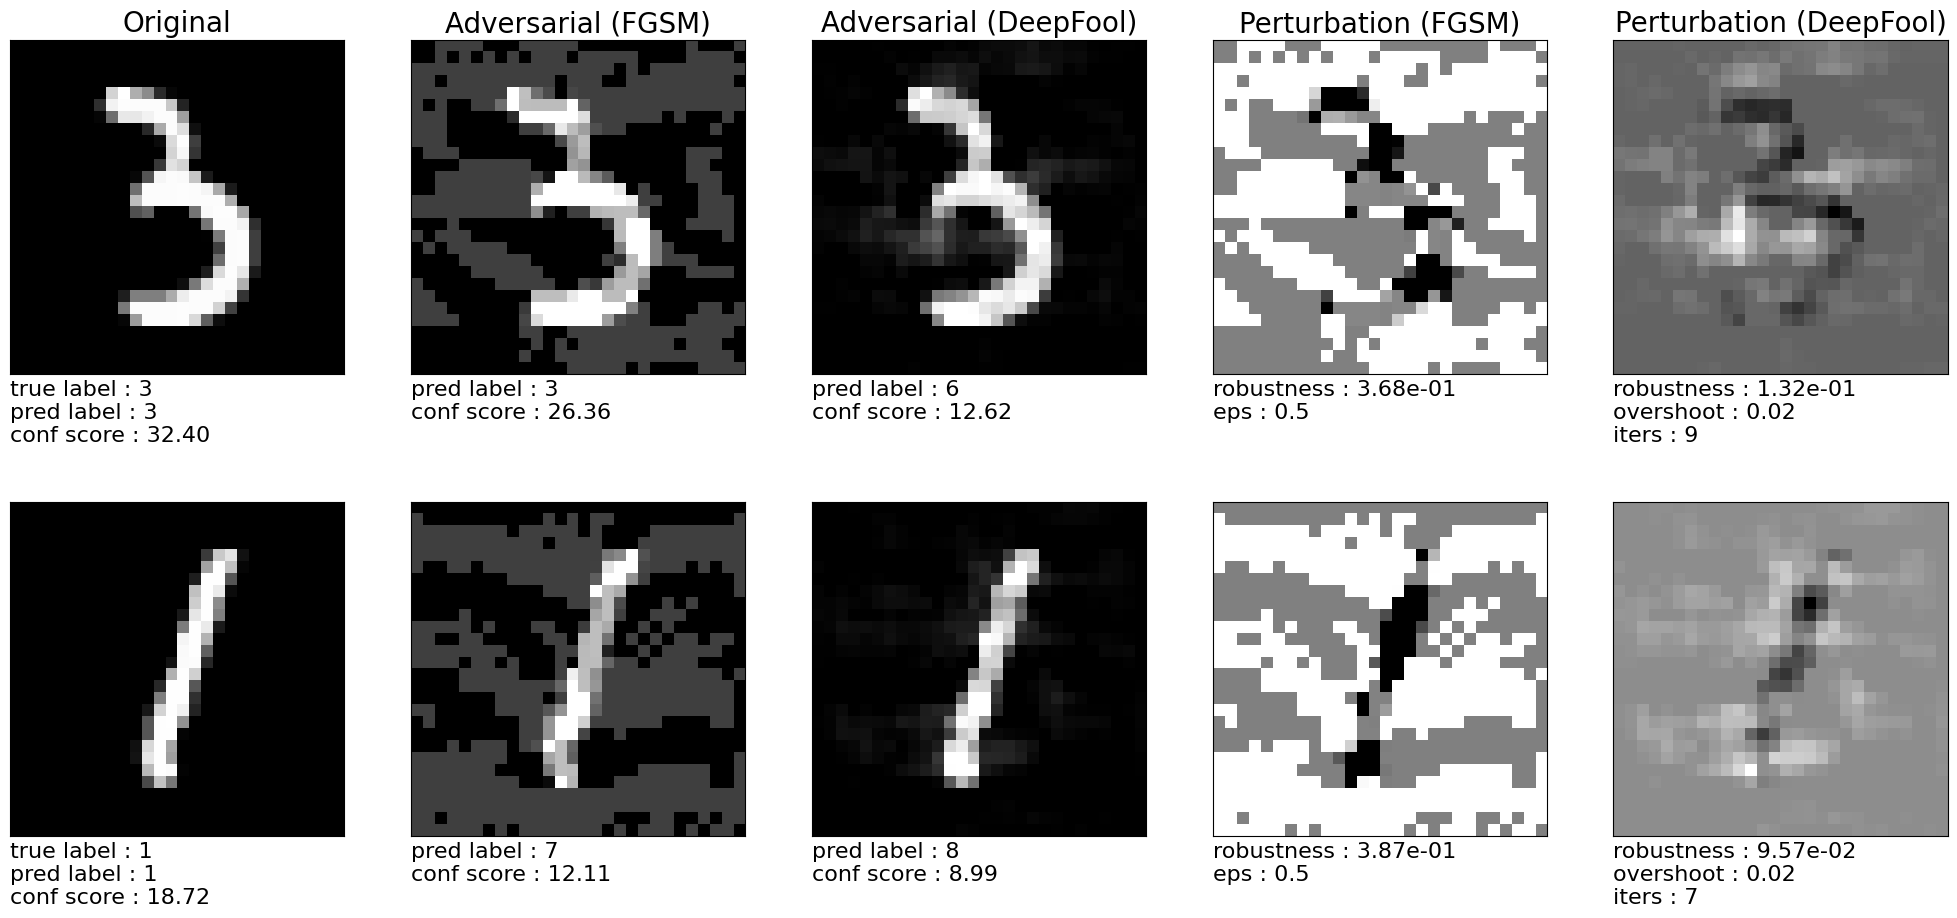

FCNet


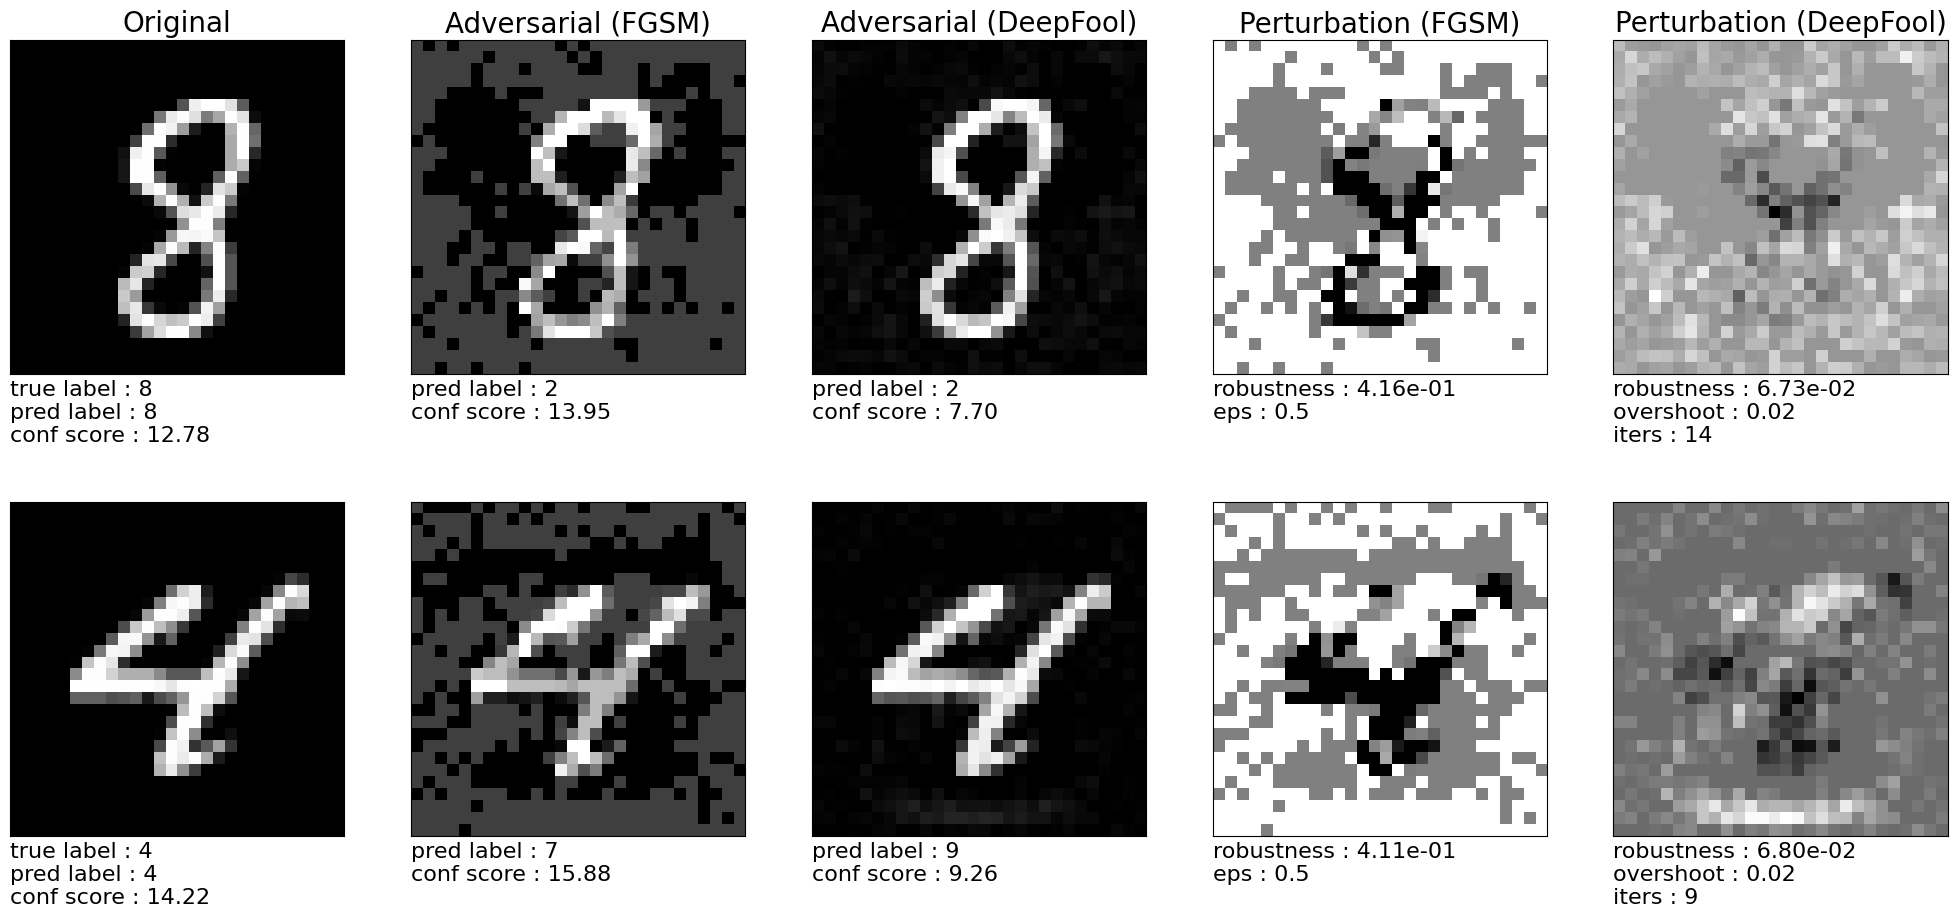

NiN


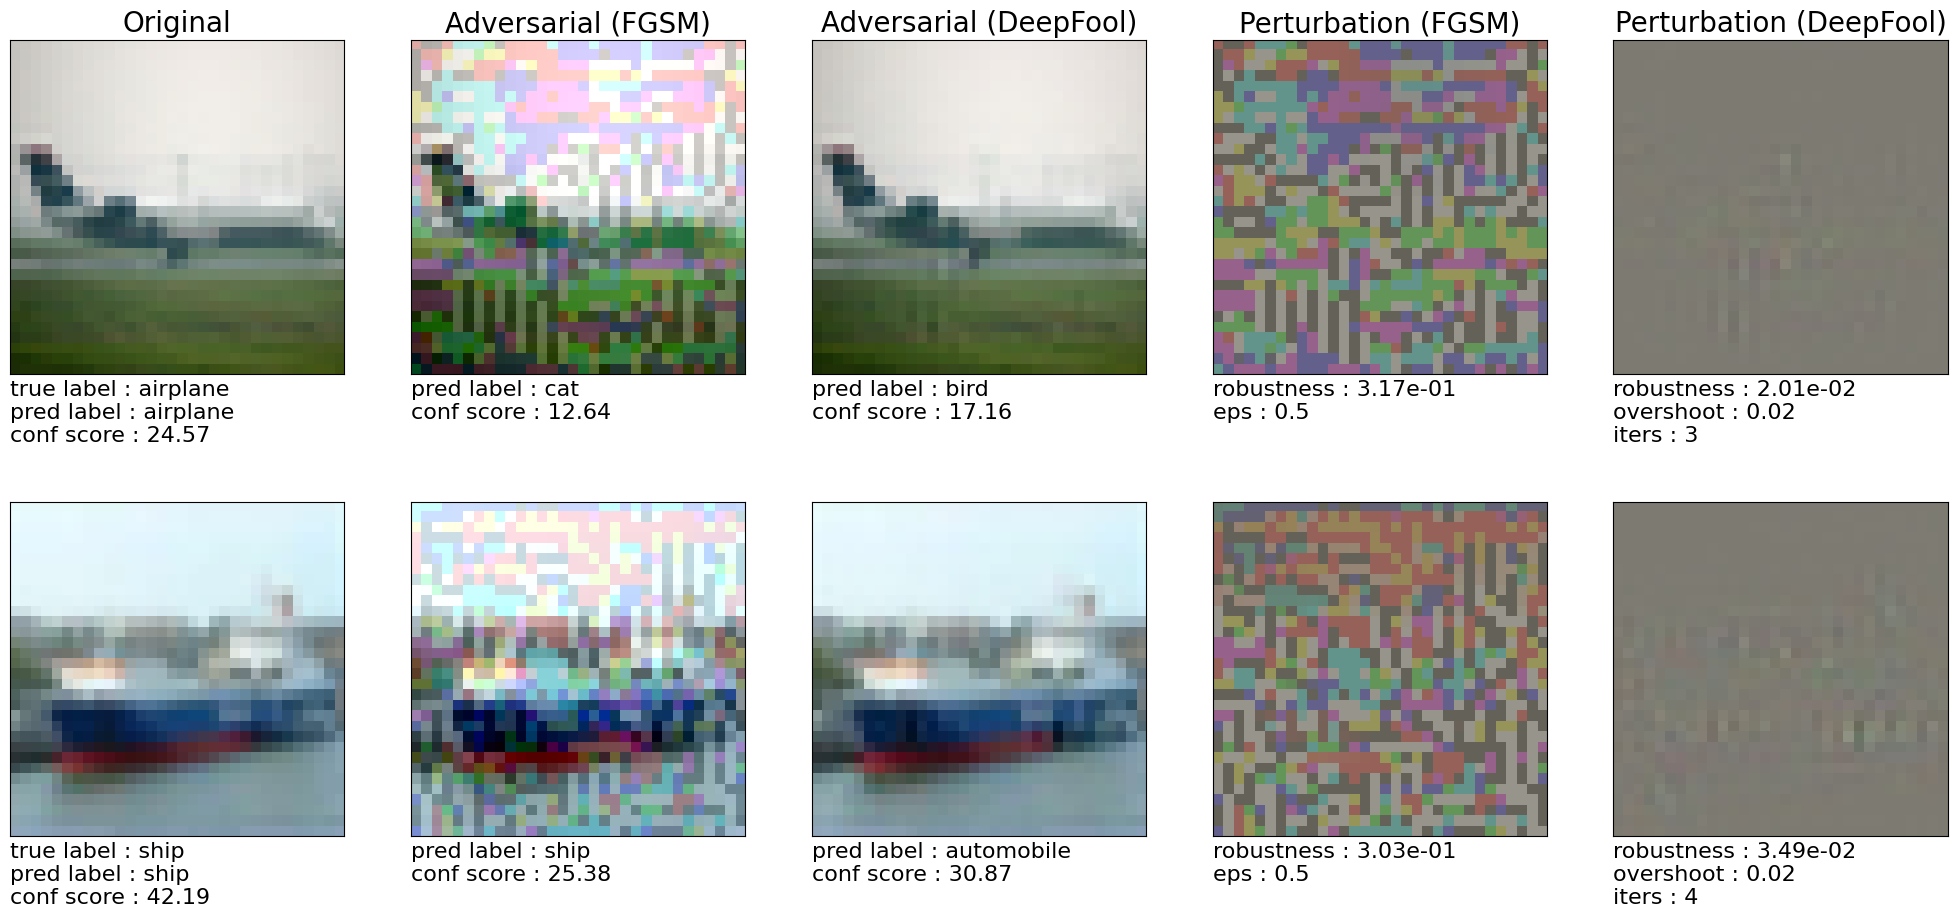

LeNet CIFAR


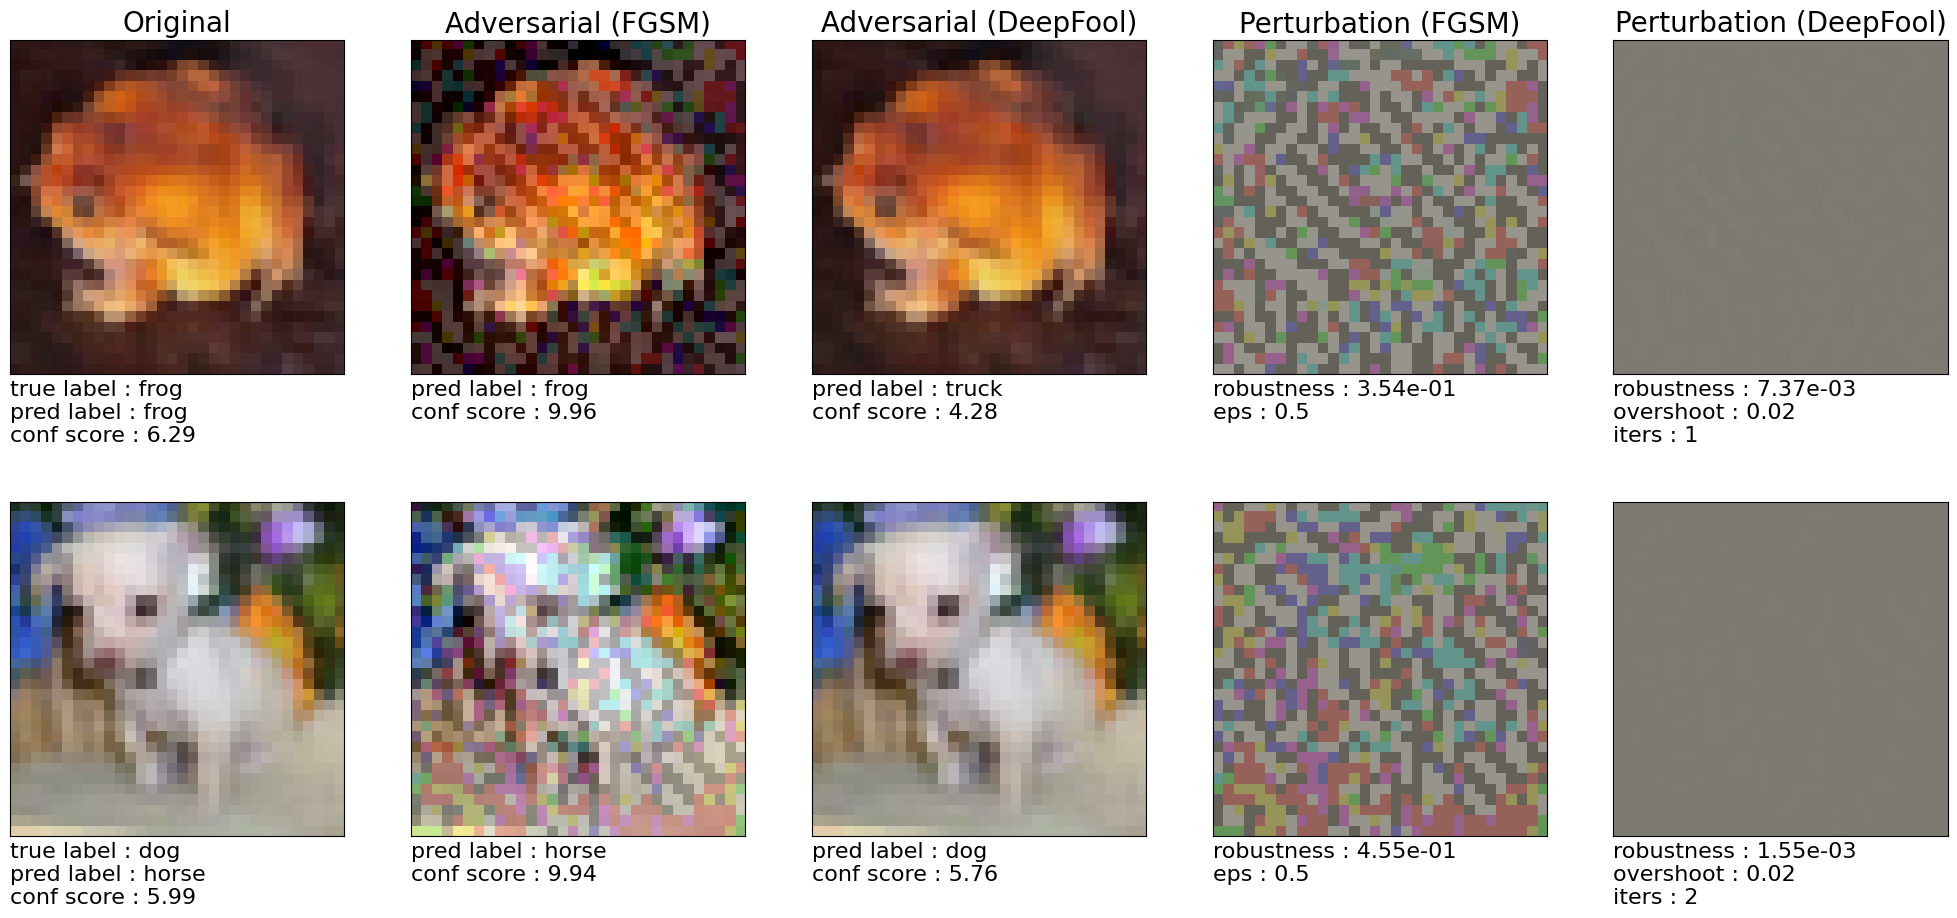

fgsm_eps =  0.9
LeNet MNIST


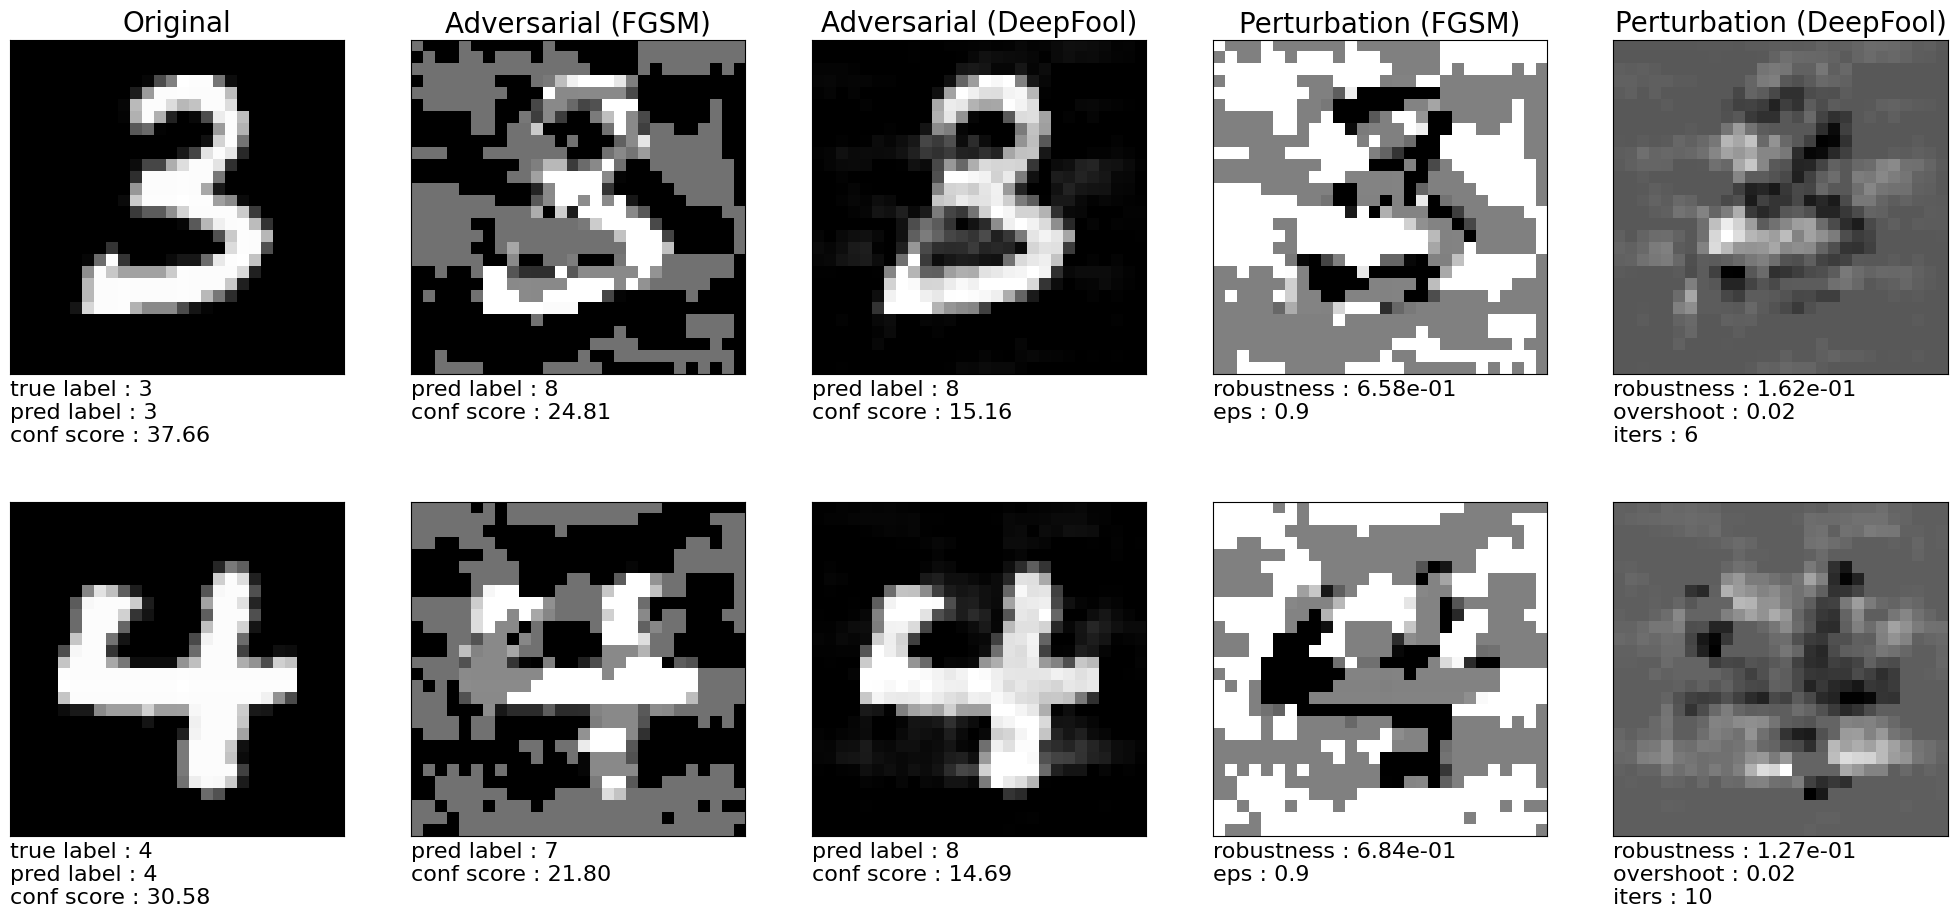

FCNet


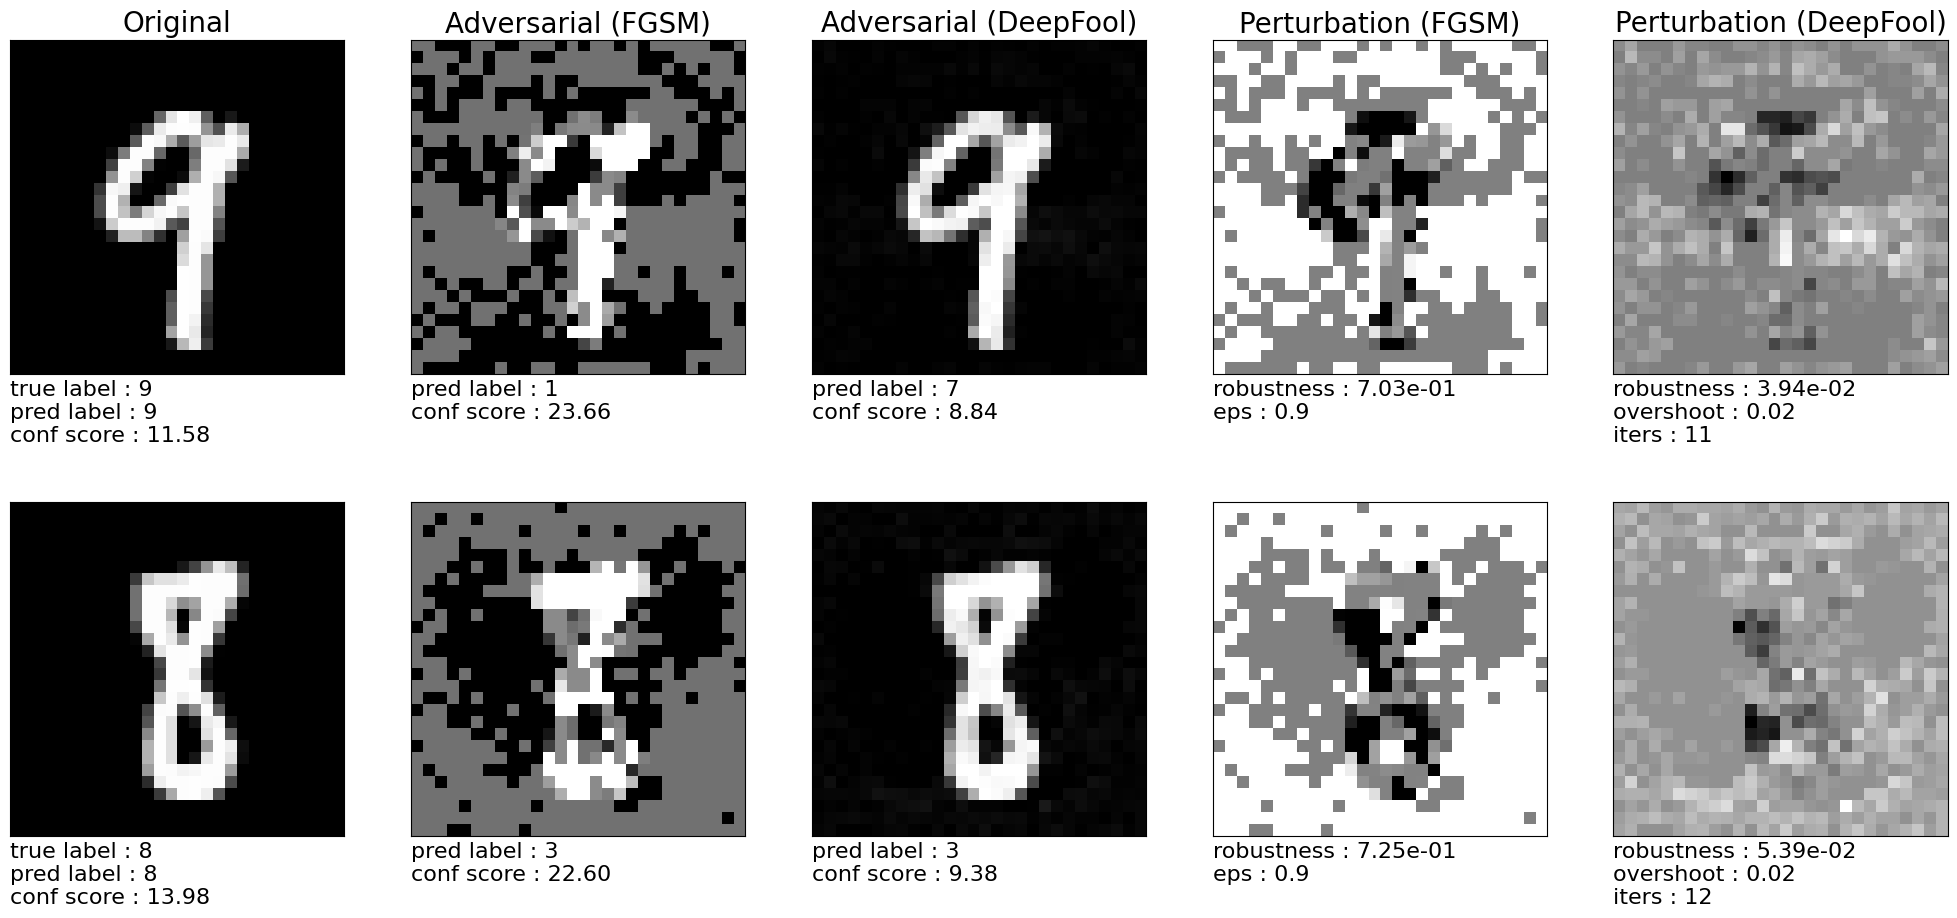

NiN


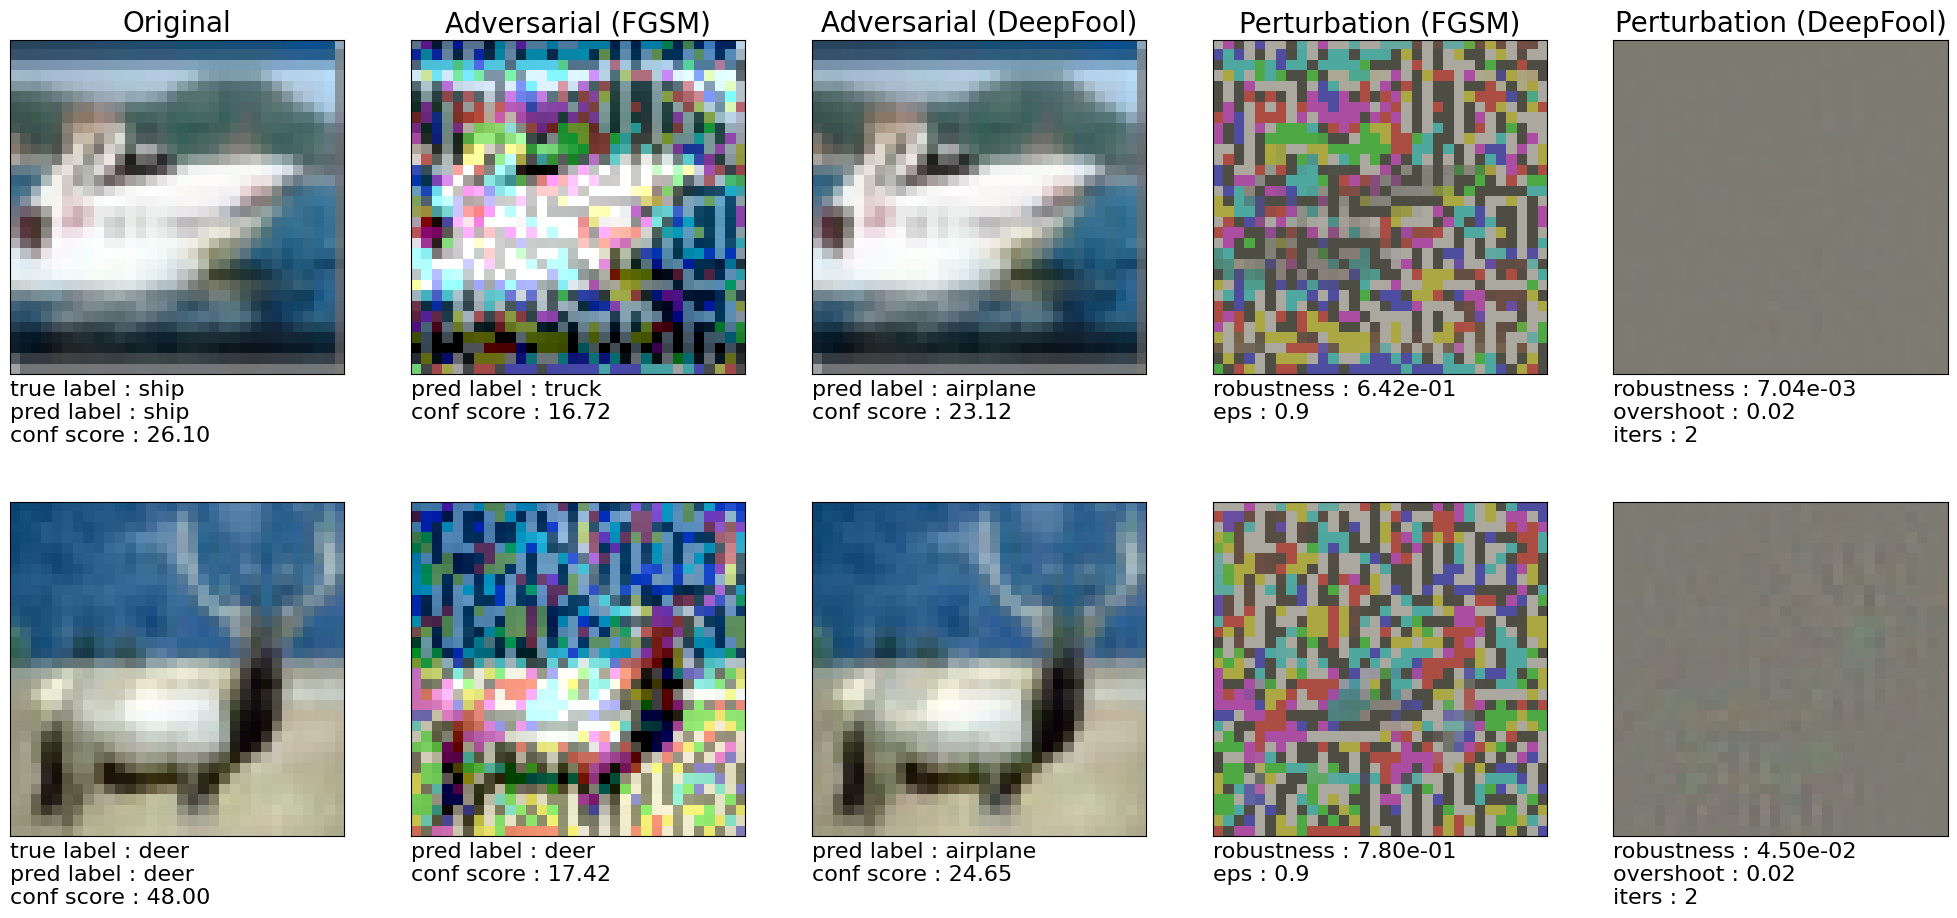

LeNet CIFAR


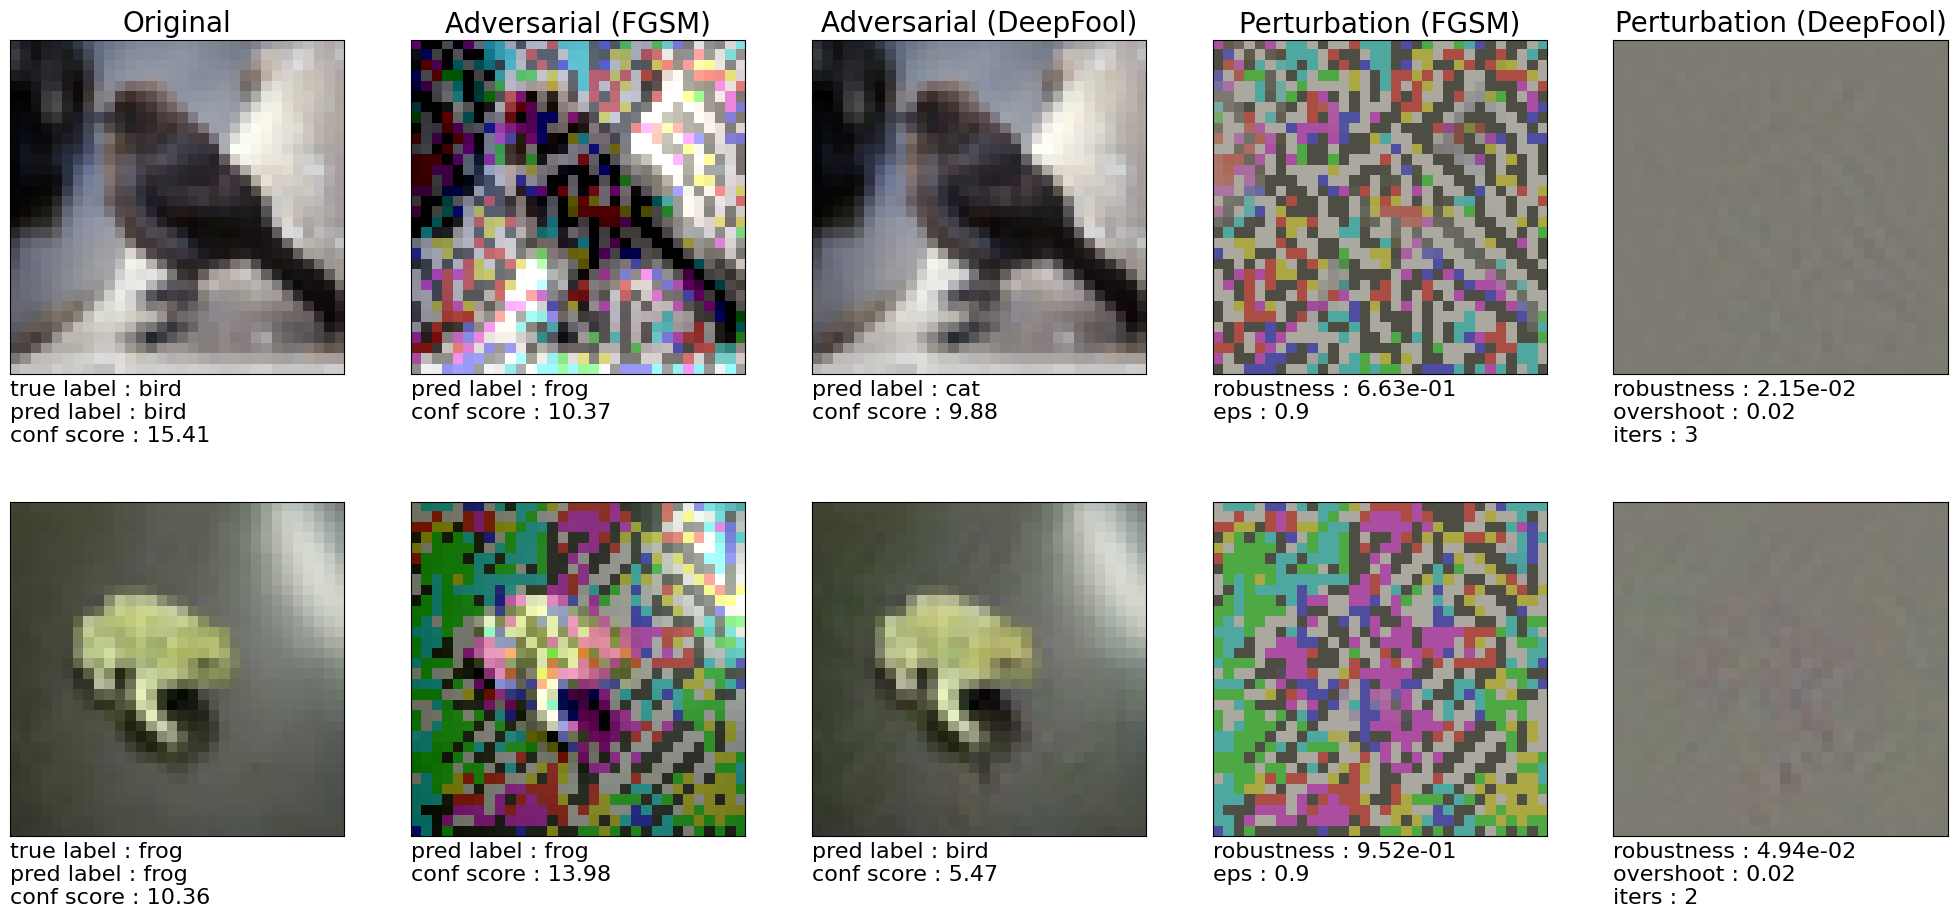

fgsm_eps =  10
LeNet MNIST


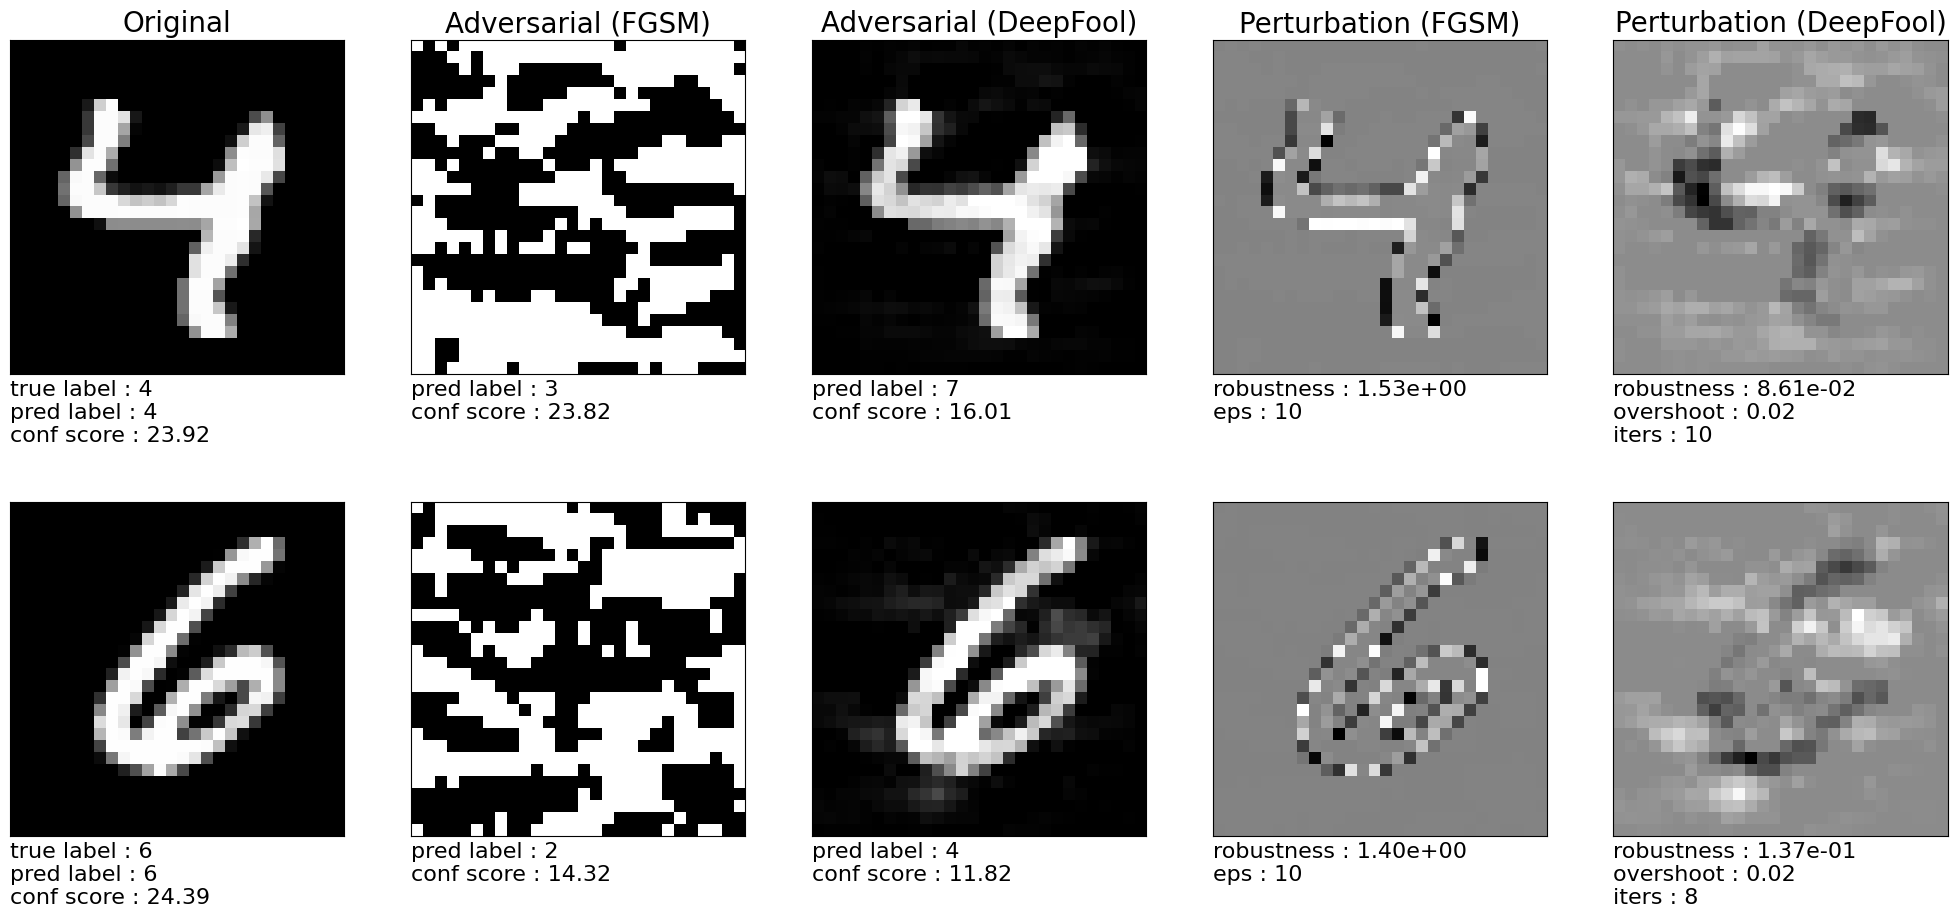

FCNet


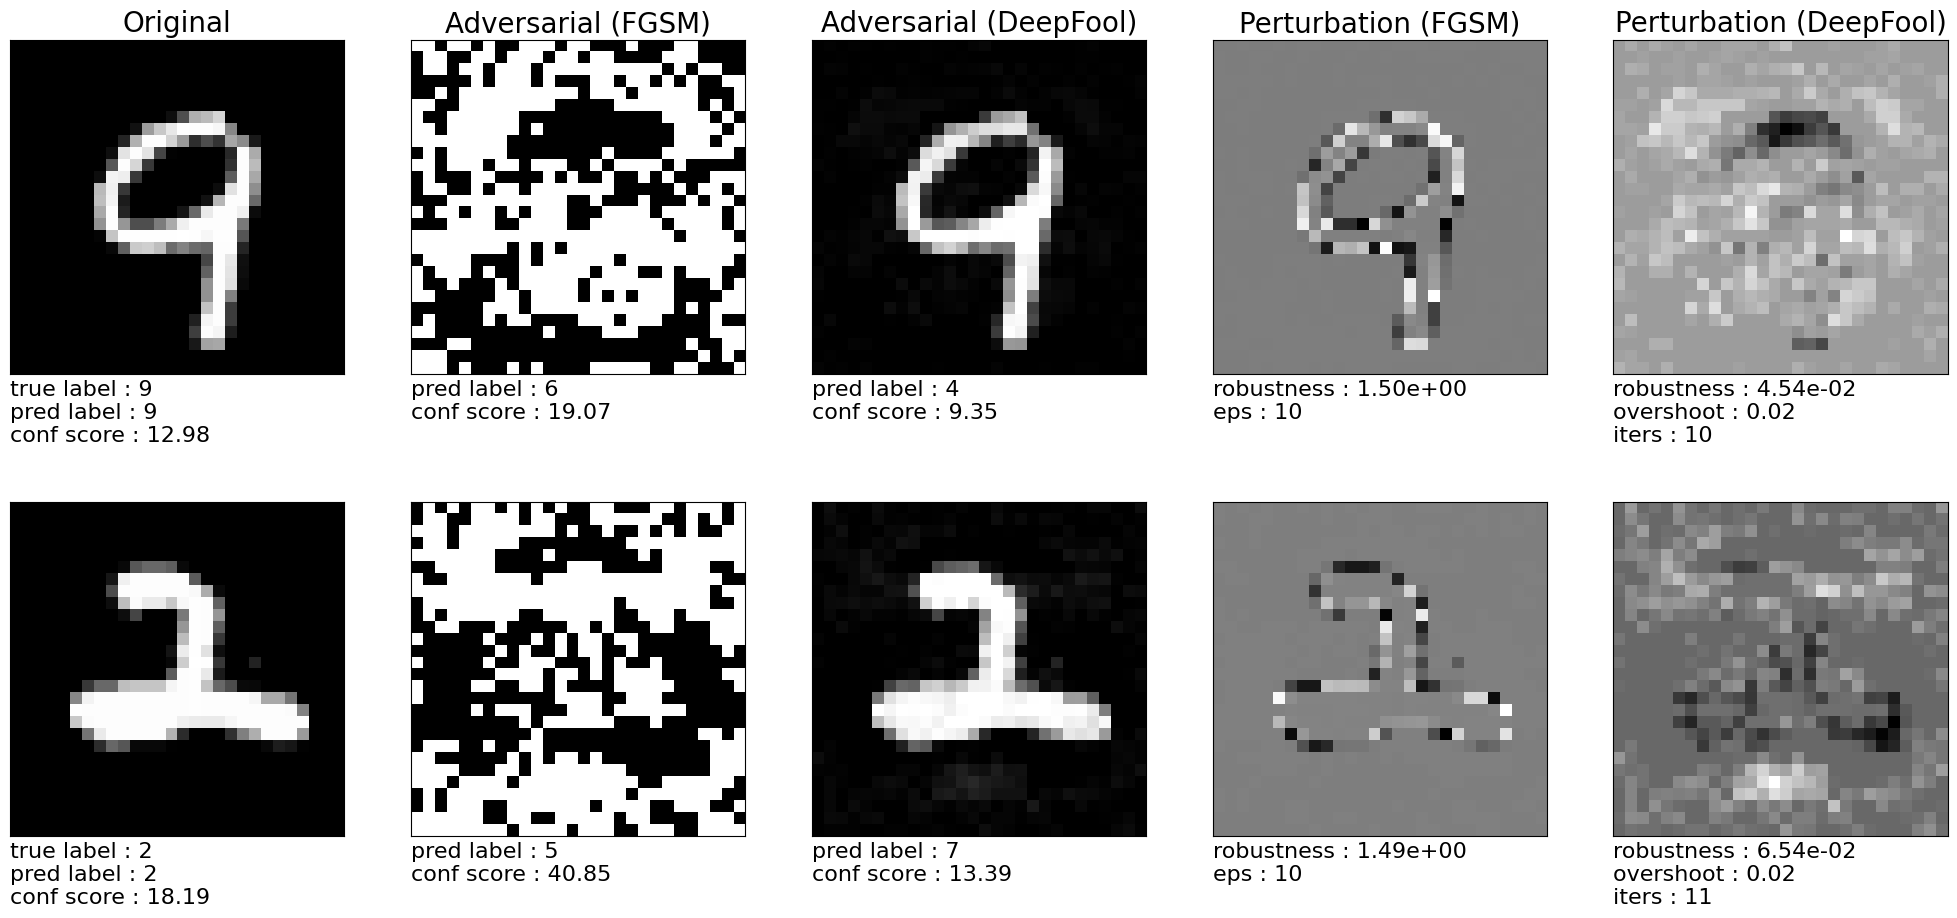

NiN


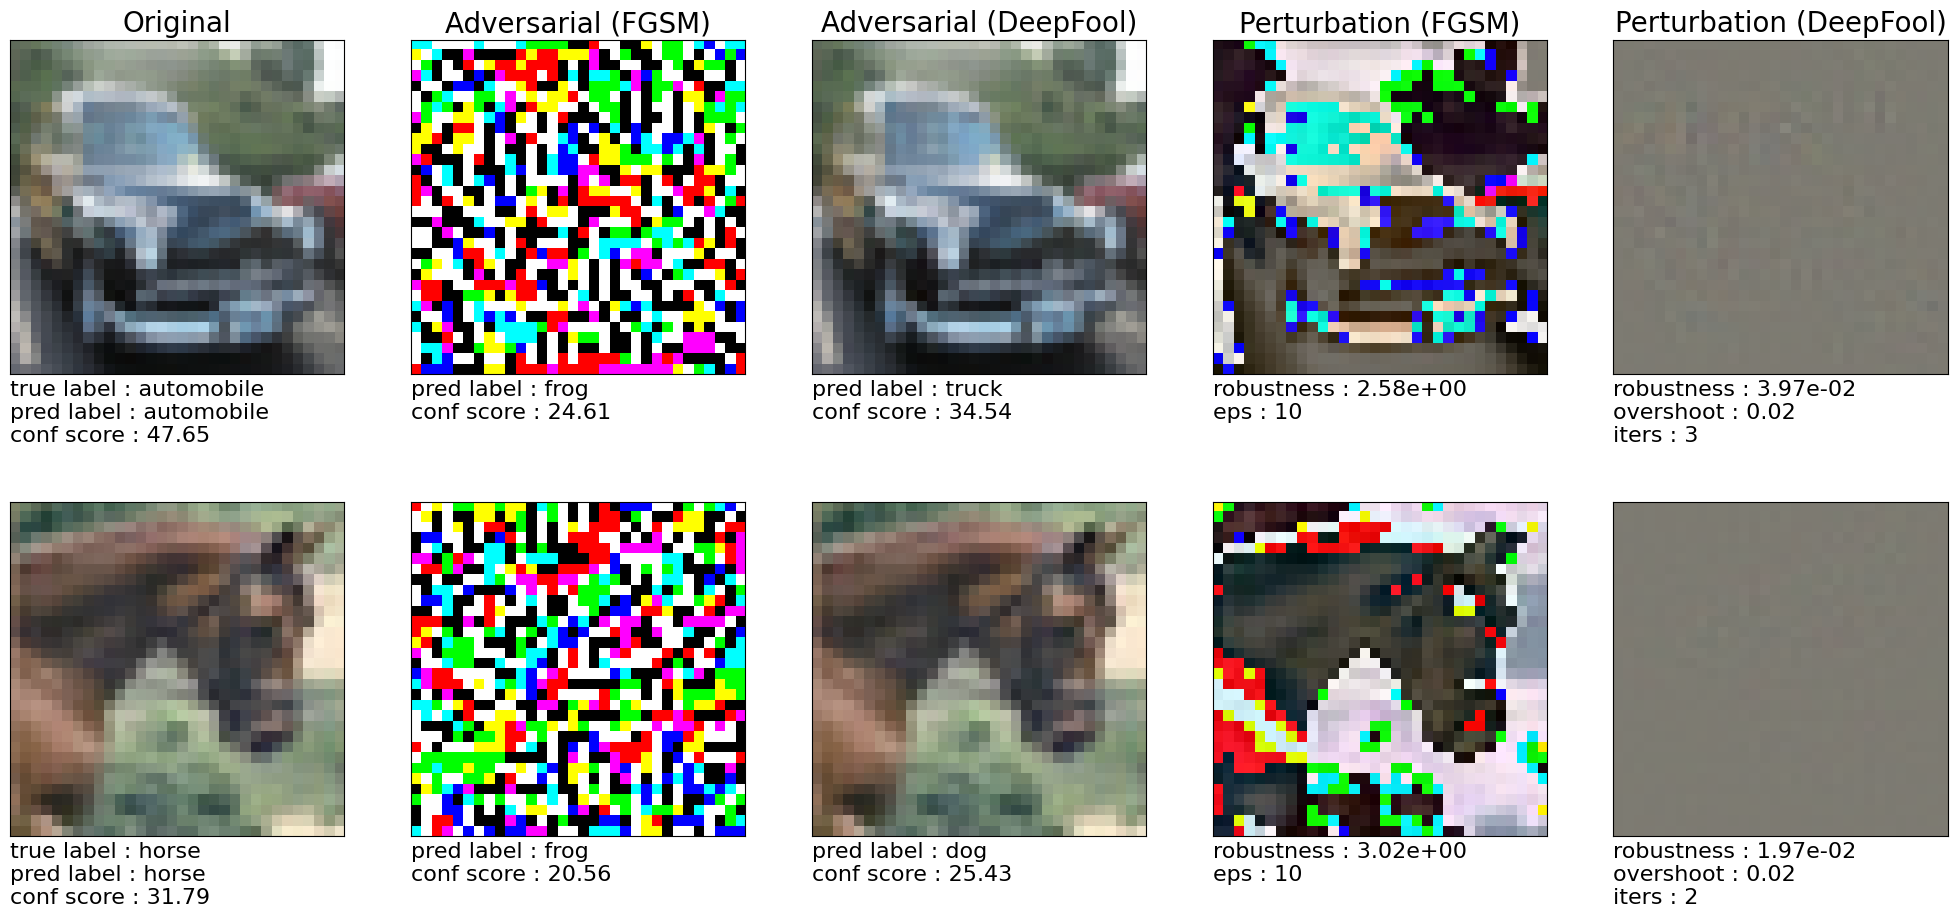

LeNet CIFAR


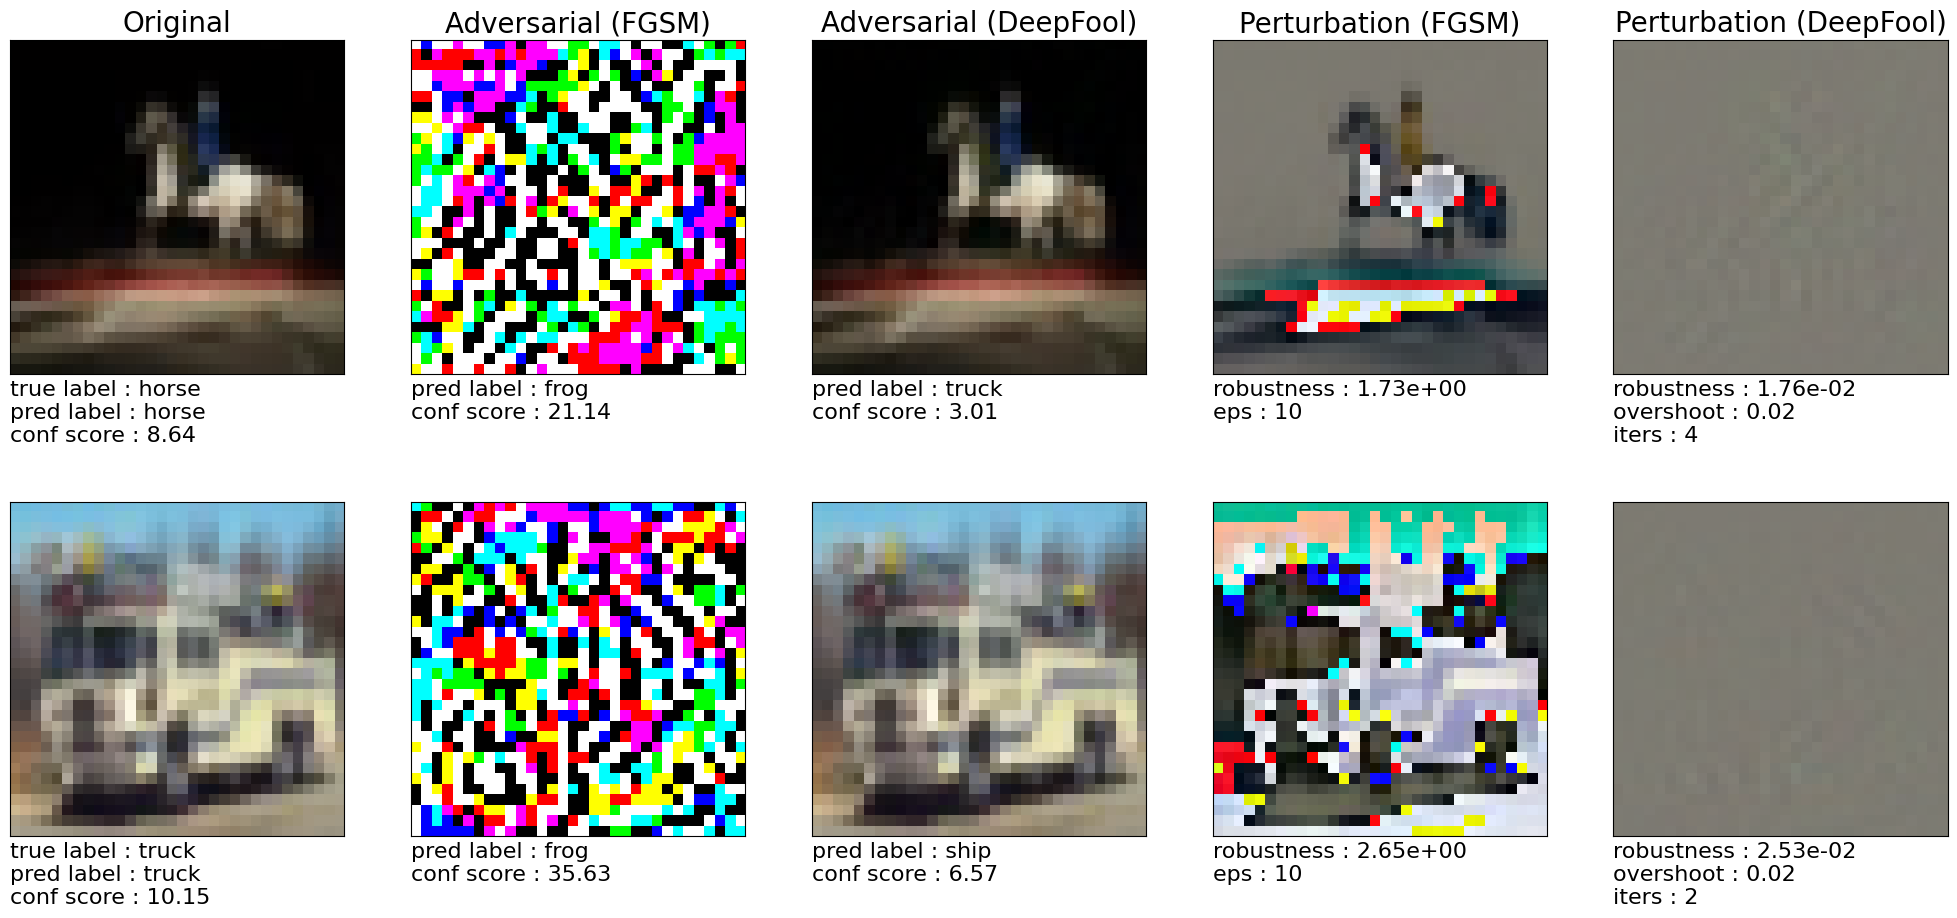

In [12]:
fgsmeps = [0.001, 0.02, 0.5, 0.9, 10]
for i in range(len(fgsmeps)):
    print('fgsm_eps = ', fgsmeps[i])
    fgsm_eps = fgsmeps[i]
    print('LeNet MNIST')
    model = LeNet_MNIST().to(device)
    model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))
    display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
                        has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
    print('FCNet')
    model = FC_500_150().to(device)
    model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=torch.device('cpu')))
    display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
                        has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
    
    print('NiN')
    model = Net().to(device)
    model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
    display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
                       has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
                       label_map=cifar_classes)
    print('LeNet CIFAR')
    model = LeNet_CIFAR().to(device)
    model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
    display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
                       has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
                       label_map=cifar_classes)

Вывод: При низких значениях fgsm_eps FGSM не смог вызвать ошибку в распознавании, в то же время при больших
значениях fgsm_eps вмешательство становиться слишком заметных.
DeepFool смог ввести сеть в заблуждение при всех значениях параметра fgsm_eps, при этом вмешательство в исходное
изображение почти не заметно.